# Online-Ad-Demand-Prediction-Using-Machine-Learning

![Image](https://i.imgur.com/toxWnTm.jpg)

## Introduction

The challenge, as described on the competition page, revolves around the impact of small details when selling used goods online. Even with a well-optimized product listing, there's a chance that demand for a product may be significantly low. This can be frustrating for sellers who may have already invested heavily in marketing.

Avito, which happens to be Russia's largest classified advertisements website, is well acquainted with this issue. On their platform, sellers often find themselves frustrated due to either insufficient demand (indicating potential issues with the product or its listing) or excessive demand (suggesting that a popular item with a good description was underpriced).

In this project, our goal is to predict the deal_probability using a machine learning model. Before that, we undertake various operations such as data cleaning and visualization to gain insights into the data. This helps us determine the essential factors that contribute to a successful deal_probability.

## Project Outline:


- Download the dataset
- Data Cleaning and Feature Engineering
- Exploratory Analysis and Visualization
- Prepare the dataset for ML training
- Train hardcoded & baseline models
- Make predictions
- Train & evaluate different models
- Tune hyperparameters for the best models
- Summary and References


### Evaluation Criteria

The regression model should be evaulated for Root Mean Squared Error 𝑅𝑀𝑆𝐸.

RMSE is defined as:



$$\ {RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} 𝑦𝑖−𝑦̂ 𝑖^2}$$

  
where y hat is the predicted value and y is the original value.



## Install and Import Libraries

In [1]:
!pip install jovian --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 798.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import jovian

In [3]:
# Execute this to save new versions of the notebook
jovian.commit(project="ML-Project")

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [4]:
import numpy as np
import pandas as pd
import os
import zipfile

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import random

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go

import matplotlib
%matplotlib inline

sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [5]:
! pip install -q kaggle #installing kaggle to import dataset

In [6]:
from google.colab import files #uploading kaggle credentials
files.upload();

Saving kaggle.json to kaggle.json


In [7]:
! mkdir ~/.kaggle

In [8]:
! cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
# Import library to download data from Kaggle
!pip install opendatasets --upgrade --quiet
import opendatasets as od

### Download Dataset

For avito price prediction let us download the dataset from kaggle dataset
https://www.kaggle.com/competitions/avito-demand-prediction/data

In [11]:
# Using Kaggle API instead of OpenDataset, because the dataset is huge and its taking too long to download

! kaggle competitions download avito-demand-prediction -f train.csv
! kaggle competitions download avito-demand-prediction -f test.csv
! kaggle competitions download avito-demand-prediction -f sample_submission.csv

 97% 310M/318M [00:04<00:00, 117MB/s] 
100% 318M/318M [00:04<00:00, 76.9MB/s]
 88% 97.0M/111M [00:01<00:00, 62.1MB/s]
100% 111M/111M [00:01<00:00, 60.2MB/s] 
  0% 0.00/3.95M [00:00<?, ?B/s]
100% 3.95M/3.95M [00:00<00:00, 201MB/s]


In [12]:
! unzip train.csv # ! unzip train_active.csv
! unzip test.csv # ! unzip test_active.csv
! unzip sample_submission.csv # ! unzip sample_submission.csv

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [13]:
! mkdir avito-demand-prediction

In [14]:
mv test.csv train.csv sample_submission.csv avito-demand-prediction

In [15]:
ls -lh avito-demand-prediction

total 1.3G
-rw-r--r-- 1 root root 8.3M Dec 16  2019 sample_submission.csv
-rw-r--r-- 1 root root 316M Dec 16  2019 test.csv
-rw-r--r-- 1 root root 909M Dec 16  2019 train.csv


### Reading CSV Files

In [16]:
train_df = pd.read_csv("/content/avito-demand-prediction/train.csv")
train_df.shape

(1503424, 18)

In [17]:
test_df = pd.read_csv("/content/avito-demand-prediction/test.csv")
test_df.shape

(508438, 17)

In [18]:
sample_submission_df = pd.read_csv("/content/avito-demand-prediction/sample_submission.csv")
sample_submission_df.shape

(508438, 2)

### Understanding the Data

In [19]:
train_df.sample(5)

item_id       user_id                 region         city  \
1092218  e86afb109dd2  5464a49ca01e           Башкортостан          Уфа   
741646   49a28f6a2866  057b82cd0e4e  Волгоградская область    Волгоград   
1271208  ddfd7490e6d0  bffc0f750a1a          Пермский край        Пермь   
1405597  344c2c1dd435  06aa1e1def74  Новосибирская область  Новосибирск   
374319   12198d659dca  64966d61ba81           Башкортостан          Уфа   

        parent_category_name              category_name             param_1  \
1092218      Для дома и дачи            Бытовая техника              Другое   
741646         Хобби и отдых              Спорт и отдых  Зимние виды спорта   
1271208         Недвижимость                   Квартиры              Продам   
1405597          Личные вещи  Одежда, обувь, аксессуары      Женская одежда   
374319                Услуги          Предложение услуг      Деловые услуги   

                      param_2      param_3                           title  \
1092218                   NaN          NaN                  Помпа для воды   
741646                    NaN          NaN                Коньки хоккейные   
1271208                Студия  Новостройка         Студия, 25 м², 9/25 эт.   
1405597              Трикотаж    42–44 (S)                 Женский свитшот   
374319   Бухгалтерия, финансы          NaN  Бухгалтерский учет организации   

                                               description      price  \
1092218  Помпа новая, в упаковке. Купили кулер, не приг...      250.0   
741646                                  Состояние отличное     2200.0   
1271208                             Квартира от подрядчика  1250000.0   
1405597                           в отл. состоянии. теплая      450.0   
374319   Ведение бухгалтерского учета в полном объеме л...        NaN   

         item_seq_number activation_date user_type  \
1092218              208      2017-03-23   Company   
741646                30      2017-03-18   Company   
1271208              639      2017-03-17   Company   
1405597              298      2017-03-23   Company   
374319                16      2017-03-15   Private   

                                                     image  image_top_1  \
1092218  1c614d548dfc05d6aa51f7968f18fa0ef411a01a0fcf3b...       1689.0   
741646   60eb3d5a4631120370b8bcec7cb7247fbc84c77828f0bf...       2645.0   
1271208                                                NaN          NaN   
1405597  04b5709042205d957743f7b62599f9d466b99bbc296ea7...        629.0   
374319   e8b2b7047000e5838e4533227e2223e20f658127432e75...       2267.0   

         deal_probability  
1092218           0.71135  
741646            0.00000  
1271208           0.10136  
1405597           0.00000  
374319            0.14286

In [20]:
test_df.sample(5)

item_id       user_id                 region       city  \
155973  d63aeb76f2b6  07deb968c393    Ярославская область    Рыбинск   
99142   6843cd7c970f  f1a94b9caa71               Удмуртия     Ижевск   
185657  f9c1b683cf24  2cb3ab2afe01  Новосибирская область     Бердск   
95372   11add56d2e91  78e55a3f4282     Краснодарский край  Краснодар   
84012   9981505372ce  02145df864ec    Саратовская область    Саратов   

       parent_category_name               category_name          param_1  \
155973         Недвижимость                     Комнаты           Продам   
99142          Недвижимость                     Комнаты              NaN   
185657          Личные вещи  Товары для детей и игрушки  Детские коляски   
95372   Бытовая электроника               Аудио и видео  Музыка и фильмы   
84012           Личные вещи      Детская одежда и обувь      Для девочек   

       param_2 param_3                          title  \
155973     NaN     NaN  Комната 14 м² в 1-к, 5/13 эт.   
99142      NaN     NaN                  Сниму комнату   
185657     NaN     NaN            Коляска прогулочная   
95372      NaN     NaN                    Аудикассета   
84012    Обувь      24           Лёгкие полуботиночки   

                                              description     price  \
155973  Продаются комнату в общежитии .Окна выходят на...  370000.0   
99142   Сниму комнату недорого . На длительный срок. П...    5000.0   
185657          коляска для девочки в хорошем состояние..    3500.0   
95372                                         TDK  новая.     350.0   
84012   Продам лёгкие полуботиночки  ( кроссовочки ) д...     230.0   

        item_seq_number activation_date user_type  \
155973               20      2017-04-15   Private   
99142                11      2017-04-18   Private   
185657                1      2017-04-18   Private   
95372                60      2017-04-16   Private   
84012               264      2017-04-14   Private   

                                                    image  image_top_1  
155973  754bf30c39804bad0fd1fafcbb4644a3afcd85e1856d52...       2219.0  
99142                                                 NaN          NaN  
185657  91343dbe72325b98fdb47bfff777a0bf857a32e3a64690...       1002.0  
95372   0448e0ed88177597afb9028cc6344c45f46a78ac233eb0...       3014.0  
84012   7076739fdce4463bae574e6e99dc5006cf976bac0dc203...         86.0

### Item Description

##### Below are the Columns of our Dataframe:-

- item_id - Ad id.

- user_id - User id.

- region - Ad region.
    
- city - Ad city.
    
- parent_category_name - Top level ad category as classified by Avito's ad model.
    
- category_name - Fine grain ad category as classified by Avito's ad model.

- param_1 - Optional parameter from Avito's ad model.
    
- param_2 - Optional parameter from Avito's ad model.
    
- param_3 - Optional parameter from Avito's ad model.
  
- title - Ad title.
    
- description - Ad description.
    
- price - Ad price.
    
- item_seq_number - Ad sequential number for user.
    
- activation_date- Date ad was placed.
    
- user_type - User type.
    
- image - Id code of image. Ties to a jpg file in train_jpg. Not every ad has an image.
    
- image_top_1 - Avito's classification code for the image.
    
- deal_probability - The target variable. This is the likelihood that an ad actually sold something. It's not possible to verify every transaction with certainty, so this column's value can be any float from zero to one.

### Cleaning Dataset

- We will start our project by cleaning the Dataset.

- Here we will look for any missing and Duplicate Values.

- Also will Downcast some columns in order to save space.

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   item_id               1503424 non-null  object 
 1   user_id               1503424 non-null  object 
 2   region                1503424 non-null  object 
 3   city                  1503424 non-null  object 
 4   parent_category_name  1503424 non-null  object 
 5   category_name         1503424 non-null  object 
 6   param_1               1441848 non-null  object 
 7   param_2               848882 non-null   object 
 8   param_3               640859 non-null   object 
 9   title                 1503424 non-null  object 
 10  description           1387148 non-null  object 
 11  price                 1418062 non-null  float64
 12  item_seq_number       1503424 non-null  int64  
 13  activation_date       1503424 non-null  object 
 14  user_type             1503424 non-

In [22]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508438 entries, 0 to 508437
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   item_id               508438 non-null  object 
 1   user_id               508438 non-null  object 
 2   region                508438 non-null  object 
 3   city                  508438 non-null  object 
 4   parent_category_name  508438 non-null  object 
 5   category_name         508438 non-null  object 
 6   param_1               485528 non-null  object 
 7   param_2               275209 non-null  object 
 8   param_3               202107 non-null  object 
 9   title                 508438 non-null  object 
 10  description           508438 non-null  object 
 11  price                 477853 non-null  float64
 12  item_seq_number       508438 non-null  int64  
 13  activation_date       508438 non-null  object 
 14  user_type             508438 non-null  object 
 15  

- Select the Only Required Columns

- Downcast data types for memory optimization

In [23]:
selected_columns = ['item_id',
                    'user_id',
                    'region',
                    'city',
                    'parent_category_name',
                    'category_name',
                    'param_1',
                    'param_2',
                    'param_3',
                    'title',
                    'description',
                    'price',
                    'activation_date',
                    'user_type',
                    'image_top_1',
                    'deal_probability']

selected_dtypes = {
    'price': 'float32',
    'user_type': 'category',
    'image_top_1' : 'float32'
}

In [24]:
columns_selected = ['item_id',
                    'user_id',
                    'region',
                    'city',
                    'parent_category_name',
                    'category_name',
                    'param_1',
                    'param_2',
                    'param_3',
                    'title',
                    'description',
                    'price',
                    'activation_date',
                    'user_type',
                    'image_top_1']

In [25]:
# Loading Dataframe with Selected Columns

train_df = pd.read_csv("/content/avito-demand-prediction/train.csv", usecols = selected_columns,
                       dtype = selected_dtypes, index_col = 'item_id', parse_dates = ['activation_date'])

In [26]:
 train_df = train_df.sample(frac = .50, random_state = 0)

In [27]:
test_df = pd.read_csv("/content/avito-demand-prediction/test.csv", usecols = columns_selected,
                       dtype = selected_dtypes, index_col = 'item_id', parse_dates = ['activation_date'])

In [28]:
train_df.shape, test_df.shape

((751712, 15), (508438, 14))

In [29]:
# Handling Missing Values

train_df.isnull().sum().sort_values(ascending = False)

param_3                 431604
param_2                 327372
description              58167
image_top_1              56217
price                    42624
param_1                  30879
user_id                      0
region                       0
city                         0
parent_category_name         0
category_name                0
title                        0
activation_date              0
user_type                    0
deal_probability             0
dtype: int64

In [30]:
train_df.isnull().mean() < 0.2

user_id                  True
region                   True
city                     True
parent_category_name     True
category_name            True
param_1                  True
param_2                 False
param_3                 False
title                    True
description              True
price                    True
activation_date          True
user_type                True
image_top_1              True
deal_probability         True
dtype: bool

In [31]:
train_df.isnull().isna().sum()

user_id                 0
region                  0
city                    0
parent_category_name    0
category_name           0
param_1                 0
param_2                 0
param_3                 0
title                   0
description             0
price                   0
activation_date         0
user_type               0
image_top_1             0
deal_probability        0
dtype: int64

In [32]:
train_df.isnull().sum().sort_values(ascending = False)

param_3                 431604
param_2                 327372
description              58167
image_top_1              56217
price                    42624
param_1                  30879
user_id                      0
region                       0
city                         0
parent_category_name         0
category_name                0
title                        0
activation_date              0
user_type                    0
deal_probability             0
dtype: int64

In [33]:
# Eliminating data with less than 20% data

threshold = 0.2
cols = train_df.columns[train_df.isnull().mean() < threshold]
train_df = train_df[cols]

In [34]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


### Dropping and Imputing Null and Duplicate Values

In [35]:
# Dropping the duplicate values

train_df.drop_duplicates( inplace = True)

In [36]:
train_df.shape

(751173, 13)

In [37]:
# Parsing Date Column

train_df['month'] = train_df.activation_date.dt.month
train_df['day_of_month'] = train_df.activation_date.dt.day
train_df['year'] = train_df.activation_date.dt.year
train_df['day_of_week'] = train_df.activation_date.dt.day_of_week
train_df['is_weekend'] = (train_df.activation_date.dt.weekday >= 5).astype(int)

In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 751173 entries, 34517db8f939 to 9657ba9add70
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   user_id               751173 non-null  object        
 1   region                751173 non-null  object        
 2   city                  751173 non-null  object        
 3   parent_category_name  751173 non-null  object        
 4   category_name         751173 non-null  object        
 5   param_1               720302 non-null  object        
 6   title                 751173 non-null  object        
 7   description           693219 non-null  object        
 8   price                 708566 non-null  float32       
 9   activation_date       751173 non-null  datetime64[ns]
 10  user_type             751173 non-null  category      
 11  image_top_1           694957 non-null  float32       
 12  deal_probability      751173 non-null  float64

In [39]:
# Evaluating Date columns for test_df

test_df['month'] = test_df.activation_date.dt.month
test_df['day_of_month'] = test_df.activation_date.dt.day
test_df['year'] = test_df.activation_date.dt.year
test_df['day_of_week'] = test_df.activation_date.dt.day_of_week
test_df['is_weekend'] = (test_df.activation_date.dt.weekday >= 5).astype(int)

In [40]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 508438 entries, 6544e41a8817 to d374d332992f
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   user_id               508438 non-null  object        
 1   region                508438 non-null  object        
 2   city                  508438 non-null  object        
 3   parent_category_name  508438 non-null  object        
 4   category_name         508438 non-null  object        
 5   param_1               485528 non-null  object        
 6   param_2               275209 non-null  object        
 7   param_3               202107 non-null  object        
 8   title                 508438 non-null  object        
 9   description           508438 non-null  object        
 10  price                 477853 non-null  float32       
 11  activation_date       508438 non-null  datetime64[ns]
 12  user_type             508438 non-null  categor

In [41]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


## Exploratory Data Analysis and Visualization


- Study the distributions of individual columns (uniform, normal, exponential)

- Detect anomalies or errors in the data (e.g. missing/incorrect values)
    
- Study the relationship of target column with other columns (linear, non-linear etc.)

- Gather insights about the problem and the dataset
    
- Come up with ideas for preprocessing and feature engineering


In [42]:
train_df.describe()

price    image_top_1  deal_probability          month  \
count  7.085660e+05  694957.000000     751173.000000  751173.000000   
mean   3.717047e+05    1242.709106          0.139351       3.000005   
std    9.451667e+07     970.811829          0.260254       0.002308   
min    0.000000e+00       0.000000          0.000000       3.000000   
25%    5.000000e+02     425.000000          0.000000       3.000000   
50%    1.300000e+03    1057.000000          0.000000       3.000000   
75%    7.000000e+03    2217.000000          0.152520       3.000000   
max    7.950101e+10    3066.000000          1.000000       4.000000   

        day_of_month      year    day_of_week     is_weekend  
count  751173.000000  751173.0  751173.000000  751173.000000  
mean       21.559344    2017.0       2.942618       0.281023  
std         4.046076       0.0       2.031702       0.449499  
min         1.000000    2017.0       0.000000       0.000000  
25%        18.000000    2017.0       1.000000       0.000000  
50%        22.000000    2017.0       3.000000       0.000000  
75%        25.000000    2017.0       5.000000       1.000000  
max        30.000000    2017.0       6.000000       1.000000

__Check for the correlation between the columns using heatmaps__

- Correlation helps to create models in the later phase

<ipython-input-43-a84053fe2ea3>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_df.corr(method='pearson')


[Text(0.5, 1.0, 'Correlation Between the Columns using HeatMap')]

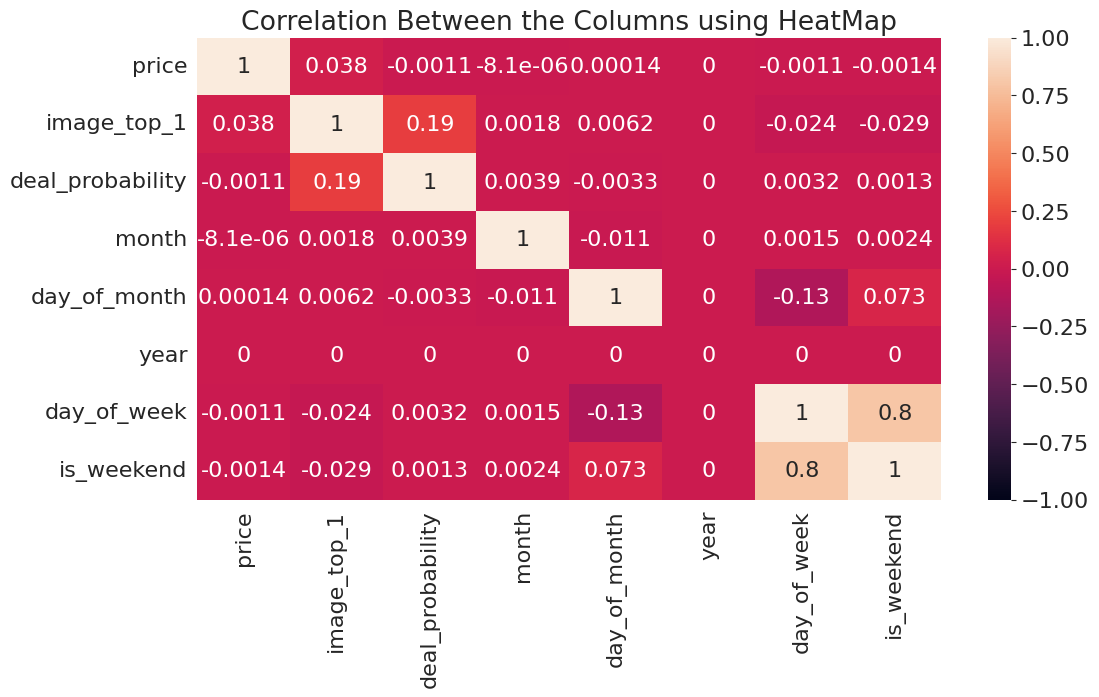

In [43]:
# Forming the correlation matrix
corr_matrix = train_df.corr(method='pearson')
corr_matrix = corr_matrix.fillna(0)  # Filling the missing values with 0

# Visualizing the correlation matrix using a heatmap
import seaborn as sns
sns.heatmap(data=corr_matrix, annot=True, vmin=-1, vmax=1).set(title='Correlation Between the Columns using HeatMap')

__Insights:__

- The above correlation matrix is a correlation of all the numeric columns of the dataset.
- Here the Darker color indicates Strong correlation between the columns, while the lighter color indicates weaker correlation.


### Checking the Skew of Data

In [44]:
import numpy as np

<ipython-input-49-03b0ece814ba>:2: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  skew = train_df.skew()


Skewness:
price               839.870850
image_top_1           0.418255
deal_probability      1.902075
month               433.348589
day_of_month         -0.006023
year                  0.000000
day_of_week           0.061361
is_weekend            0.974318
dtype: float64


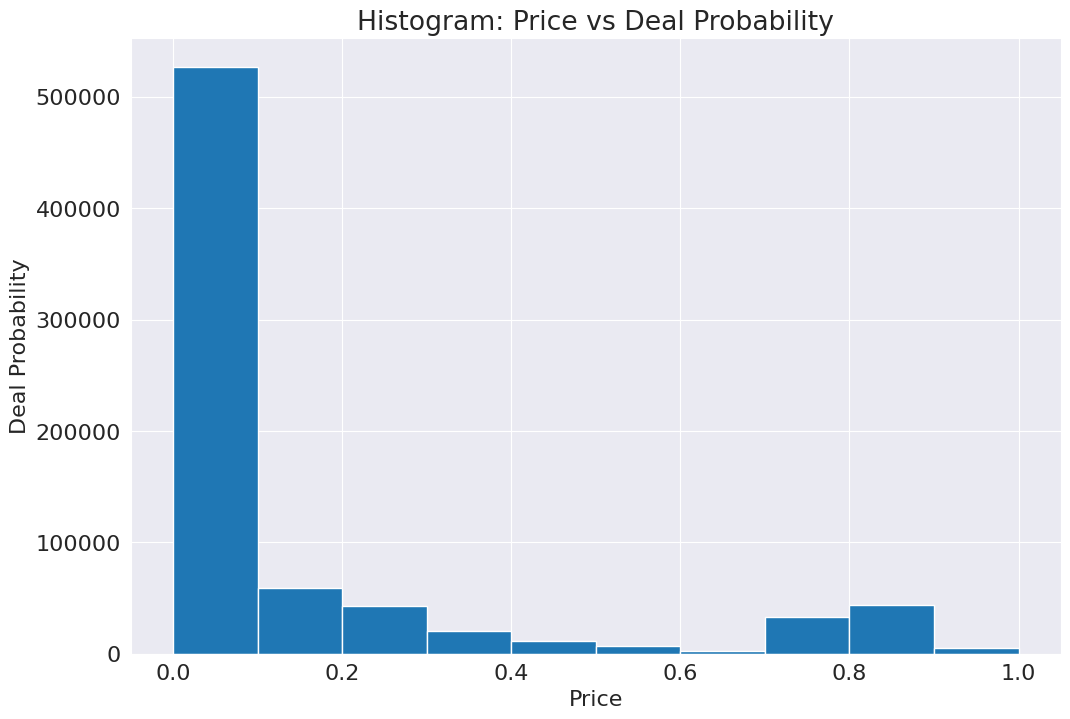

In [49]:
# Calculate skewness of the DataFrame
skew = train_df.skew()
print("Skewness:")
print(skew)

# Plot a histogram of price and deal_probability columns
train_df.plot(kind='hist', x='price', y='deal_probability', figsize=(12, 8), legend = False)

plt.xlabel('Price')
plt.ylabel('Deal Probability')
plt.title('Histogram: Price vs Deal Probability')
plt.show()

__Insight:__

- From the above Graph we can see the Skew of this data.

- The skewness of the price column is positive, it suggests that there are more higher-priced items in the dataset, resulting in a right-skewed distribution. On the other hand, a negative skewness value for the deal_probability column indicates a left-skewed distribution, suggesting that there are more lower deal probabilities.

- The skewness of the data tells us about the asymmetry or lack of symmetry in the distribution. It indicates the extent to which the data deviates from a perfectly symmetrical distribution.



In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


### Checking the Stats of the price Column

In [ ]:
train_df.deal_probability.isna().sum()

0

In [ ]:
train_df['year'].value_counts()

2017    751173
Name: year, dtype: int64

Both the Train and Test Dataframes are from the year 2017

In [ ]:
train_df.month.value_counts()

3    751169
4         4
Name: month, dtype: int64

All the data is from the month March and April

Let's Plot some Graphs and find Insights by doind Exploratory Data Analysis on Train Dataset.

Checking the Correlation of Test Dataframe

In [ ]:
test_df.describe()

price    image_top_1     month   day_of_month      year  \
count  4.778530e+05  465829.000000  508438.0  508438.000000  508438.0   
mean   2.798189e+05    1297.958984       4.0      14.985650    2017.0   
std    5.364218e+06     961.065308       0.0       2.092457       0.0   
min    0.000000e+00       0.000000       4.0      12.000000    2017.0   
25%    5.000000e+02     467.000000       4.0      13.000000    2017.0   
50%    1.500000e+03    1132.000000       4.0      15.000000    2017.0   
75%    8.600000e+03    2218.000000       4.0      17.000000    2017.0   
max    3.000060e+09    3066.000000       4.0      20.000000    2017.0   

         day_of_week     is_weekend  
count  508438.000000  508438.000000  
mean        2.763963       0.231497  
std         1.951071       0.421790  
min         0.000000       0.000000  
25%         1.000000       0.000000  
50%         3.000000       0.000000  
75%         4.000000       0.000000  
max         6.000000       1.000000

<ipython-input-50-6672c5d2c3e0>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = test_df.corr(method='pearson')


[Text(0.5, 1.0, 'Correlation Between the Columns using HeatMap')]

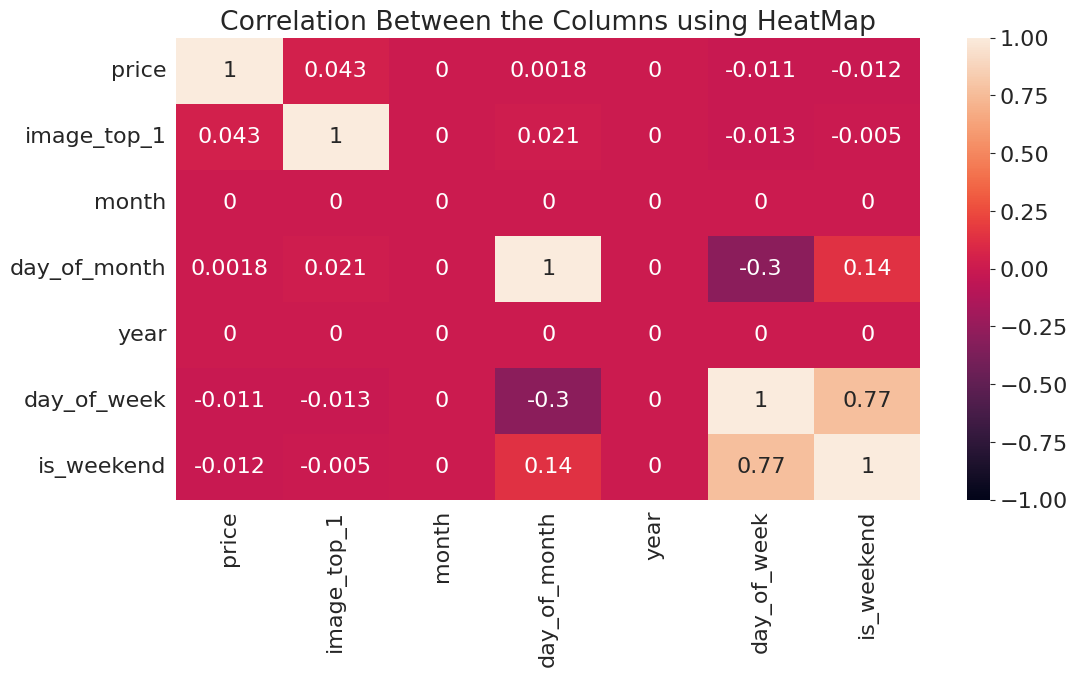

In [50]:
# Forming the correlation matrix on Test_df
corr_matrix = test_df.corr(method='pearson')
corr_matrix = corr_matrix.fillna(0)  # Filling the missing values with 0

# Visualizing the correlation matrix using a heatmap
import seaborn as sns
sns.heatmap(data=corr_matrix, annot=True, vmin=-1, vmax=1).set(title='Correlation Between the Columns using HeatMap')

__Insights:__

- The above correlation matrix is a correlation of all the numeric columns of the test_df dataset.
- Here the Darker color indicates Strong correlation between the columns, while the lighter color indicates weaker correlation.

In [ ]:
test_df['year'].value_counts()

2017    508438
Name: year, dtype: int64

Test Dataset is also from the year 2017

In [ ]:
test_df['month'].value_counts()

4    508438
Name: month, dtype: int64

Test Dataset data is from the month April

In [ ]:
test_df.isna().sum().sort_values(ascending = False)

param_3                 306331
param_2                 233229
image_top_1              42609
price                    30585
param_1                  22910
user_id                      0
user_type                    0
day_of_week                  0
year                         0
day_of_month                 0
month                        0
description                  0
activation_date              0
region                       0
title                        0
category_name                0
parent_category_name         0
city                         0
is_weekend                   0
dtype: int64

In [ ]:
# We will drop few columns from test_df, as they have high missing value pecentage
# Also we will drop "activation_date" column from both the dataframes, as we don't need it

train_df.drop(["activation_date"],axis=1,inplace=True)
test_df.drop(["activation_date"],axis=1,inplace=True)

# Dropping "param_2 and param_3" columns from test_df
test_df.drop(["param_2"],axis=1,inplace=True)
test_df.drop(["param_3"],axis=1,inplace=True)

In [ ]:
train_df.shape, test_df.shape

((751173, 17), (508438, 16))

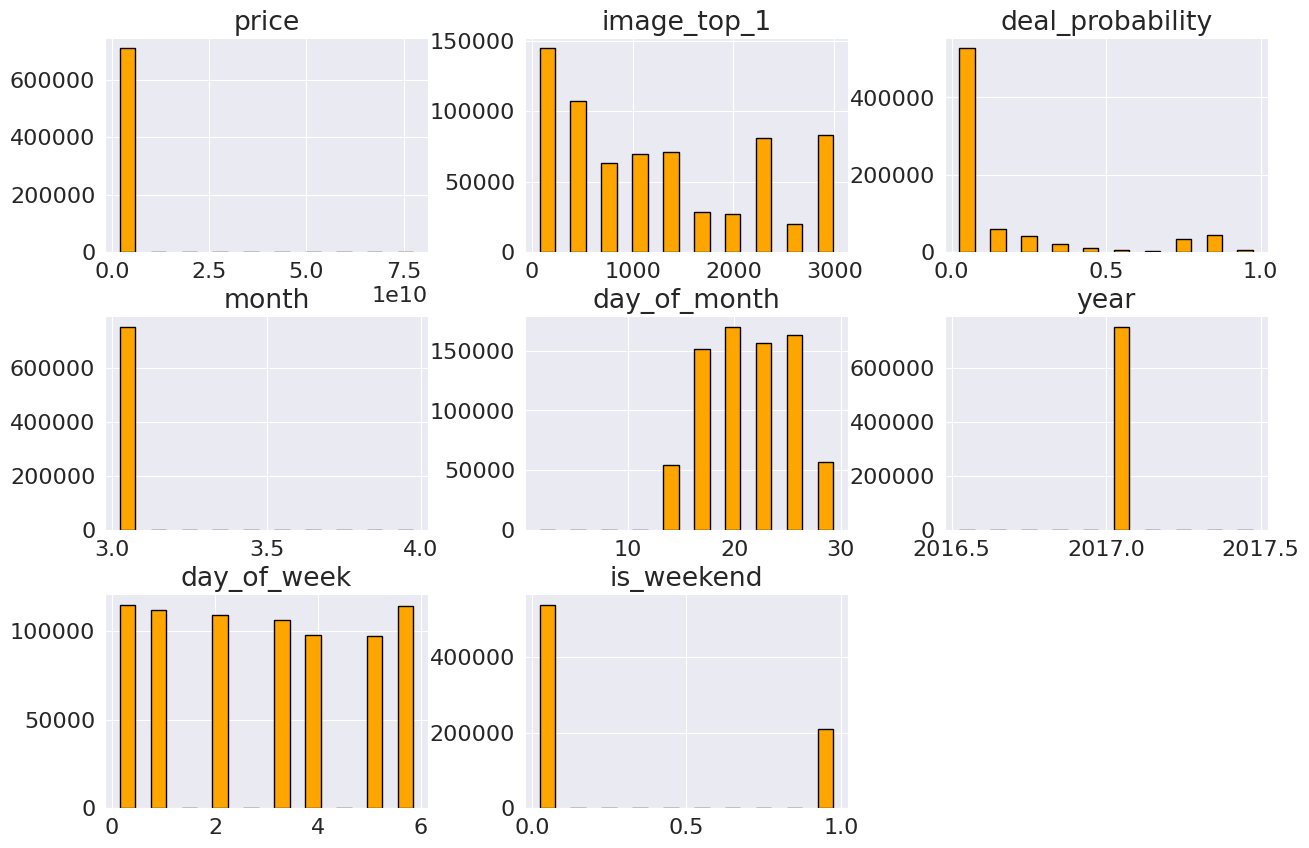

In [ ]:
from matplotlib import pyplot

train_df.hist(rwidth=0.5, figsize=(15,10), color = 'orange', edgecolor = 'black')
pyplot.show();

__Insights:__

- Price Column has Right Skewness, which means its positively Skewed

- From image_top column we can see, in the beginning it have the heighest value.

- deal_probablity column has the heighest value at 0.1 .

- train_df has only data for the month "March"

- day_of_month shows data for Half of month only i.e. from 15th till 30th.

- Year is 2017

- day_of_week have heighest values on Saunday and Saturday, rest are also acceptable.

- is_weekend have acceptable values of 0,1.


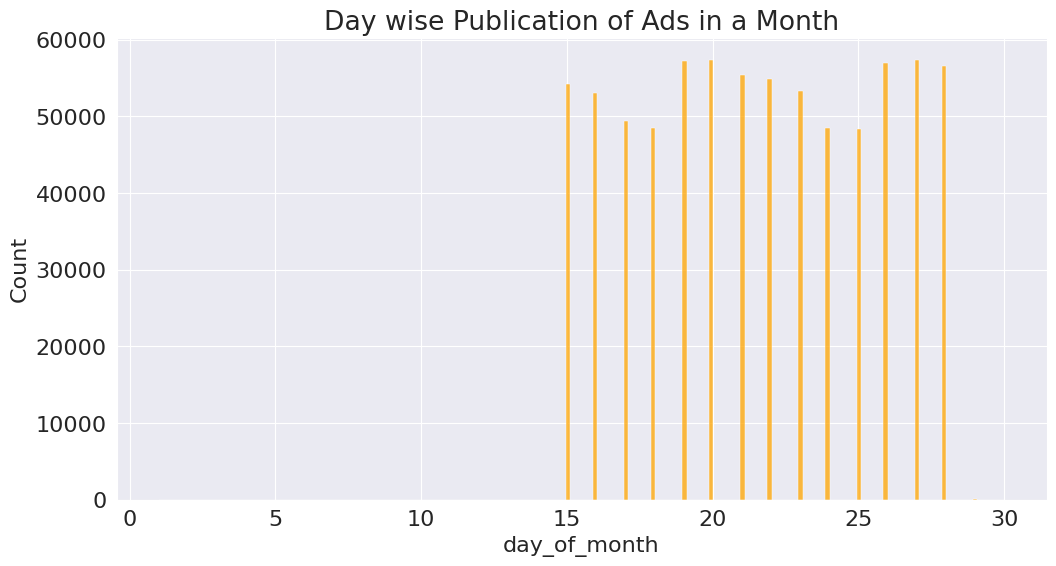

In [51]:
sns.histplot(data=train_df, x='day_of_month', color = 'orange').set(title='Day wise Publication of Ads in a Month');

__Insights:__

- We can see the Ads are published from 15th till 28th of March.

- Not all days in the months are used to publish the Ads.

__Insights:__

0 - Monday, 1 - Tuesday, 2 - Wednesday, 3 - Thursday, 4 - Friday, 5 - Saturday and 6 - Sunday.

- Deal probability increases as the ads count fall and deal probability reaches a maximum on day 6th of the week.
    
- Ads count are highest on weekends (assuming day 0 and day 6 are the weekend).
    
- Deal probability fall off during mid-week, potentially due to mid of the week effect

- The countplot provides a visual representation of the number of advertisements, while the pointplot shows the average deal probability.

<ipython-input-59-7dd7e22cb4b4>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 99)` for the same effect.

  sns.pointplot(x="day_of_week", y="deal_probability", data=train_df, ci=99, ax=ax2, color="black")


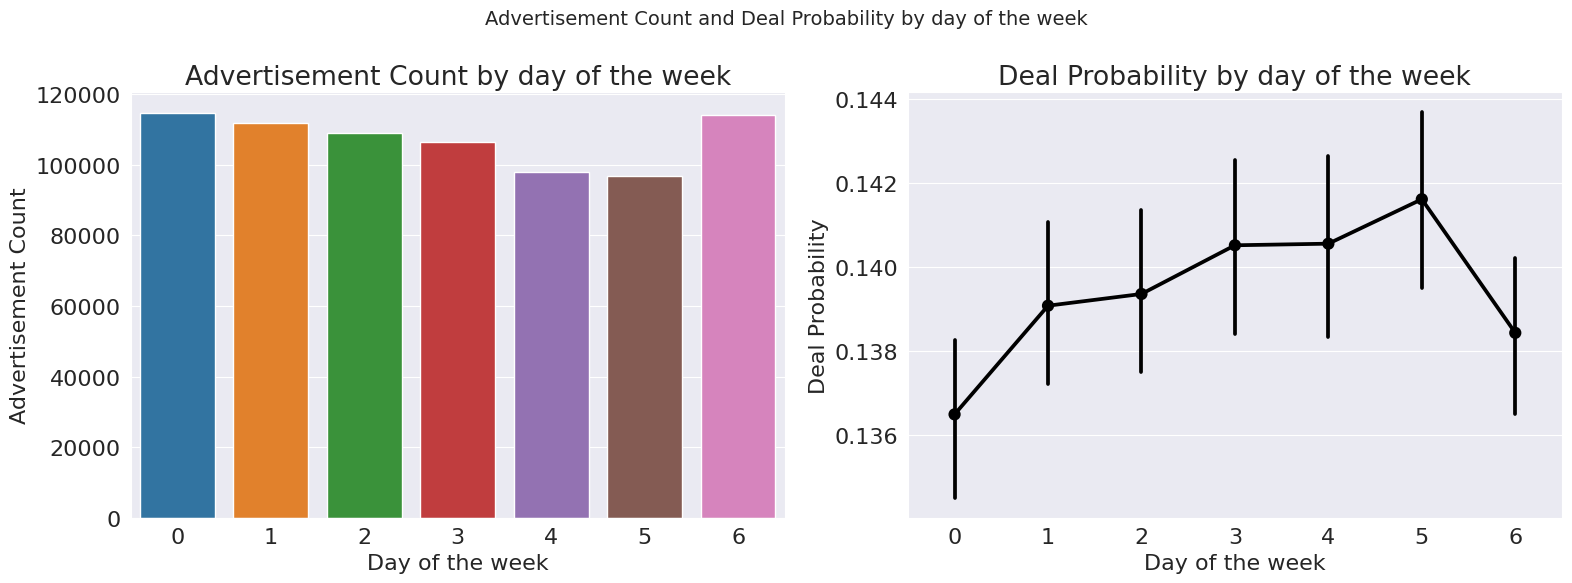

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plt.suptitle("Advertisement Count and Deal Probability by day of the week", fontsize=14)

sns.countplot(x="day_of_week", data=train_df, ax=ax1)
ax1.set_xlabel("Day of the week")
ax1.set_ylabel("Advertisement Count")
ax1.set_title("Advertisement Count by day of the week")

sns.pointplot(x="day_of_week", y="deal_probability", data=train_df, ci=99, ax=ax2, color="black")
ax2.set_xlabel("Day of the week")
ax2.set_ylabel("Deal Probability")
ax2.set_title("Deal Probability by day of the week")

plt.tight_layout()
plt.show()


__Insights:__

0 - Monday, 1 - Tuesday, 2 - Wednesday, 3 - Thursday, 4 - Friday, 5 - Saturday and 6 - Sunday.

- From the First graph we can see the advertisement counts are high on weekends.

- But from the second Graph w can see, deal_probablity is less on weekends. It is high when ad counts are less.

- Deal probability fall off during mid-week, potentially due to mid of the week effect

*Let's see how different factors or variables might influence the deal probability, by checking distribution of Target variable deal_probablity with other variables.*

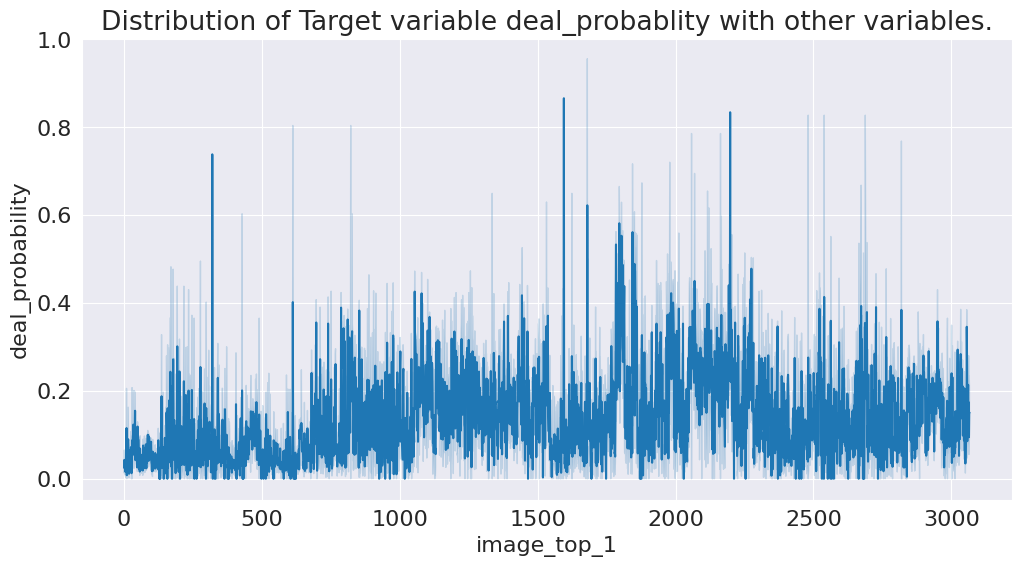

In [52]:
sns.lineplot(data=train_df, x='image_top_1', y='deal_probability').set(title='Distribution of Target variable deal_probablity with other variables.');

__Insights:__

- From the above Line Plot we can see that how Image_top can affect the deal_probablity. It shows its quite High.

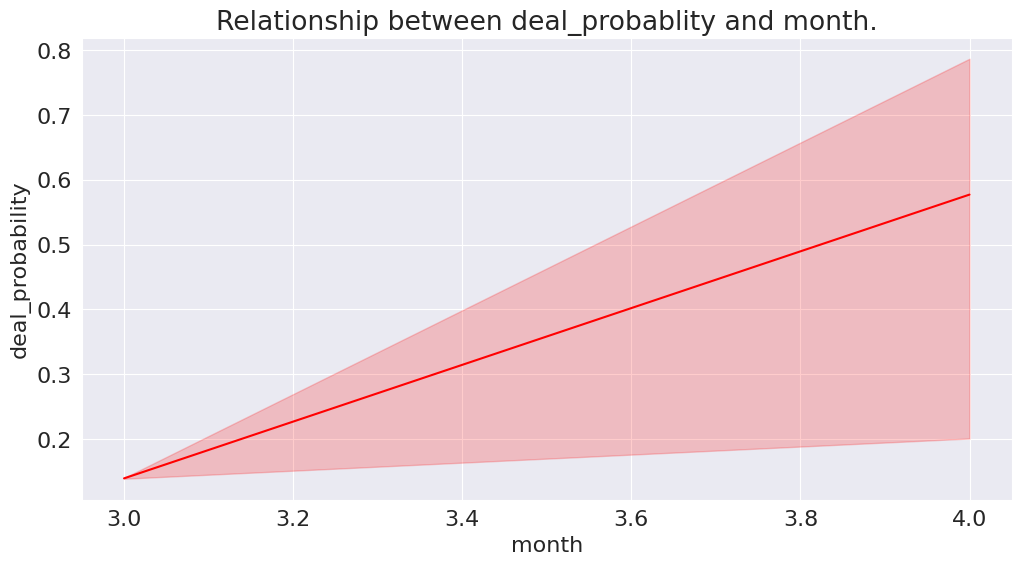

In [53]:
sns.lineplot(data=train_df, x='month', y='deal_probability', color = 'red').set(title='Relationship between deal_probablity and month.');

__Insights:__

- The above graph indicates, the deal_probablity increased as the month progressed.

- The shaded region around the line is often used to represent the uncertainty or variability in the deal_probability values for each month.

- A wider shaded region indicates higher variability, while a narrower shaded region suggests lower variability.

In [55]:
fig = px.pie(train_df,
             names="user_type",
             title='User type distribution')
fig.show();

Output hidden; open in https://colab.research.google.com to view.

![PieChart](https://i.imgur.com/eihJTNm.png)

__Insights:__

- The above chart tells us that, Private users are in maximum number i.e. 71.6% to give online Ads.

- Company users are only 23.1% to give online Ads.

- Shops are the least i.e. 5.35% to give advertisements.

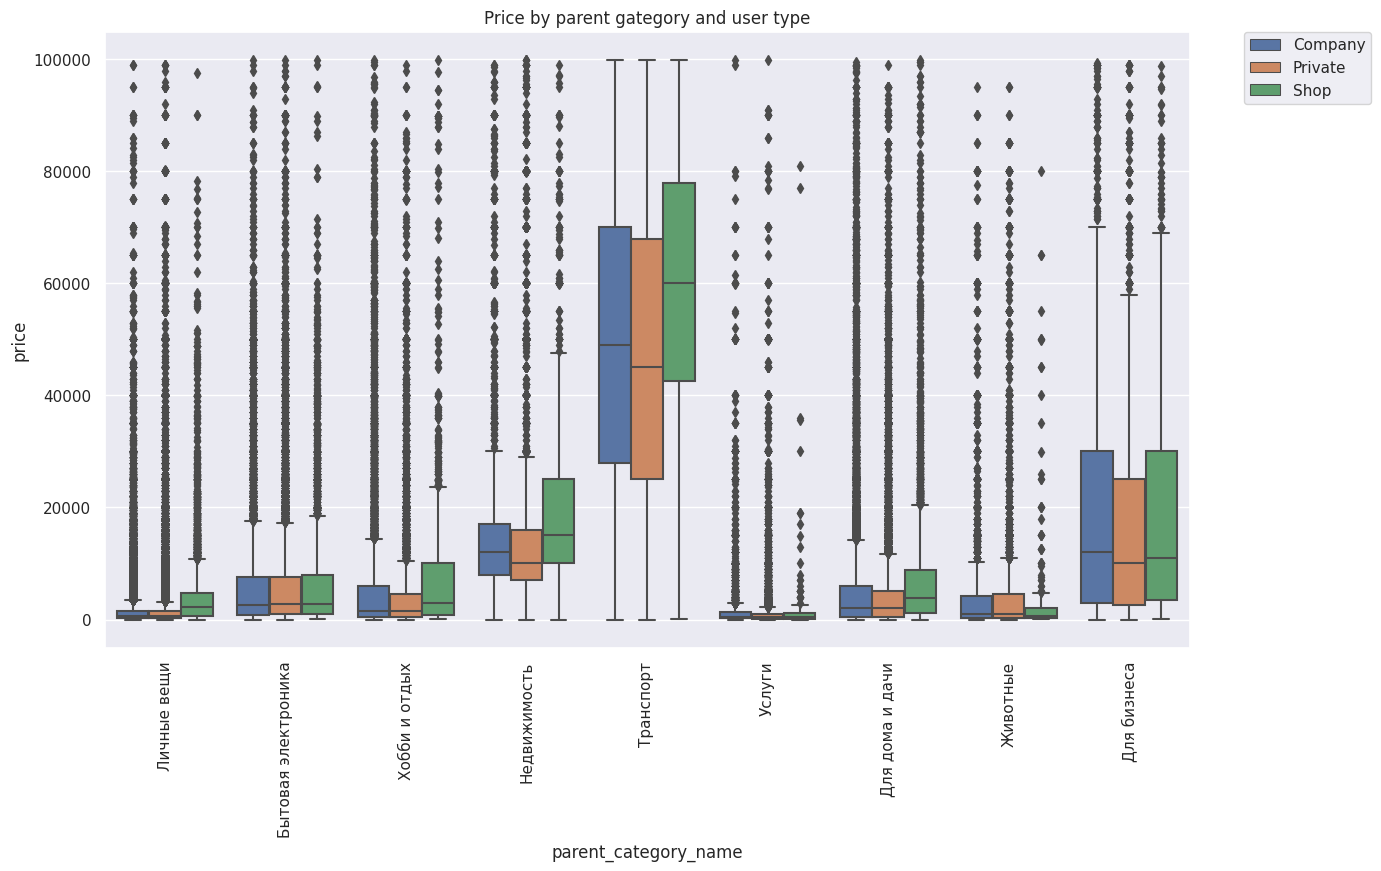

In [56]:
sns.set(rc = {'figure.figsize': (14, 8)})

df_train_ = train_df[train_df.price.isnull() == False]
df_train_ = train_df.loc[train_df.price < 100000.0]

sns.boxplot(x = "parent_category_name",
           y = "price",
           hue = "user_type",
           data = df_train_)

plt.title("Price by parent gategory and user type")
plt.xticks(rotation = "vertical")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

__Insights:__

- From the above plot we can say, ther are few outliers also.
- From Whiskers we can identify outliers in the data, which are points that are significantly different from the majority of the data points.
- Above we can see Outliers are represented as individual points beyond the whiskers.


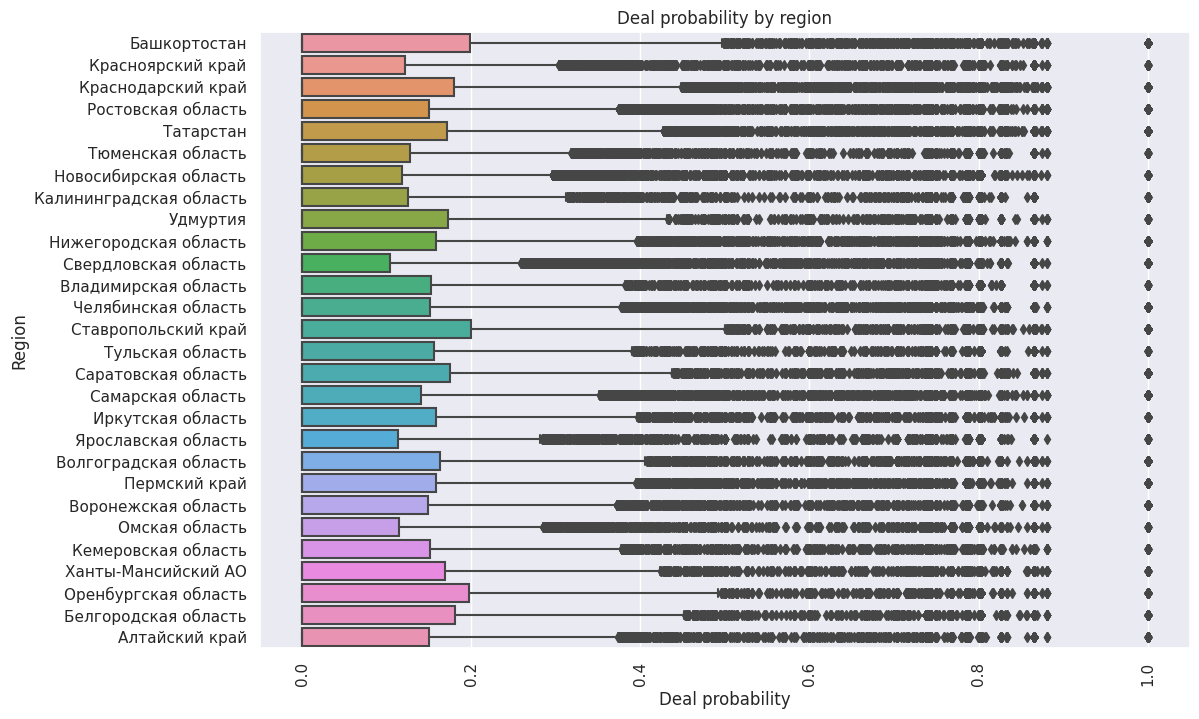

In [57]:
plt.figure(figsize=(12,8))
sns.boxplot(y="region", x="deal_probability", data=train_df)
plt.xlabel('Deal probability', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.title("Deal probability by region")
plt.xticks(rotation='vertical')
plt.show()

__Insights:__

- There are few regions with a probablity of 0.2 maximum.

### Defining the Input and Target Columns

In [58]:
# Removing user_id column from input columns
input_cols = ['region',
              'city',
              'parent_category_name',
              'category_name',
              'param_1',
              'title',
              'price',
              'user_type',
              'image_top_1',
              'month',
              'day_of_month',
              'year',
              'day_of_week',
              'is_weekend'
              ]
target_col = 'deal_probability'

In [59]:
inputs_df, targets = train_df[input_cols].copy(), train_df[target_col].copy()

In [60]:
# Identify numeric and categorical columns

numeric_cols = ['price', 'image_top_1']
categorical_cols = ['region', 'city', 'parent_category_name', 'category_name', 'param_1', 'title',
                    'user_type', 'month', 'day_of_month', 'day_of_week', 'is_weekend']

In [61]:
train_df[numeric_cols].isna().sum()

price          42607
image_top_1    56216
dtype: int64

In [62]:
inputs_df[numeric_cols].isna().sum()

price          42607
image_top_1    56216
dtype: int64

In [63]:
# Since both of the DF contains NaN values, we will replace them with some number.

inputs_df['price'].fillna(-9999, inplace=True)
test_df['price'].fillna(-9999, inplace=True)

In [64]:
inputs_df['image_top_1'].fillna(-9999, inplace=True)
test_df['image_top_1'].fillna(-9999, inplace=True)

In [65]:
# Dropping the Year column
inputs_df.drop(labels='year', axis=1, inplace=True)
test_df.drop(labels='year', axis=1, inplace=True)

In [66]:
inputs_df[categorical_cols].isna().sum()

region                      0
city                        0
parent_category_name        0
category_name               0
param_1                 30871
title                       0
user_type                   0
month                       0
day_of_month                0
day_of_week                 0
is_weekend                  0
dtype: int64

### Feature Selection

In machine learning, the data we provide to our models as inputs are referred to as features. Each column in our dataset represents a specific feature. To create an effective model, it is important to select and use only the essential features during the training process.

__Why feature Selection__

The purpose of feature selection in machine learning is to ensure that our models receive high-quality input data. In machine learning, the principle "garbage in, garbage out" holds true. If we feed our models with irrelevant or noisy data, the output will likely be unreliable or inaccurate.

When training a machine learning model, we typically gather a large amount of data to help the model learn effectively. Feature selection is a technique that involves reducing the number of input variables, or features, used by the model. By selecting only the relevant features and eliminating noise in the data, we can improve the model's performance.

The process of feature selection involves automatically identifying and choosing the most important features for the specific problem we are trying to solve. It allows us to include or exclude certain features without modifying them, ultimately reducing noise and the overall size of the input data.

In [67]:
#Imputing NaN value with 'Missing' data

inputs_df['param_1'].fillna('Missing', inplace=True)
test_df['param_1'].fillna('Missing', inplace=True)

In [68]:
# Dropping 'description' and 'user_id' from test_df

test_df.drop(labels='description', axis=1, inplace=True)
test_df.drop(labels='user_id', axis=1, inplace=True)

## Model Selection

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

import sklearn

from matplotlib import pyplot

### Step 1: Imputation Technique

Impute Numeric Variables with mean of the variable

In [70]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(weights='uniform').fit(inputs_df[numeric_cols])

inputs_df[numeric_cols] = imputer.transform(inputs_df[numeric_cols])
test_df[numeric_cols] = imputer.transform(test_df[numeric_cols])

We have checked for any null data already. There is none so we will move ahead.

### Step 2. Scale Data With Min Max Scaler

In [71]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

inputs_df[numeric_cols] = scaler.fit_transform(inputs_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

### Step 3. Transforming Categories With Encoding process

In [72]:
# Encoding labels of multiple Categorical columns
from sklearn.preprocessing import LabelEncoder

inputs_df[categorical_cols] = inputs_df[categorical_cols].apply(LabelEncoder().fit_transform)
inputs_df.head()

region  city  parent_category_name  category_name  param_1  \
item_id                                                                    
34517db8f939       1  1536                     4             10      107   
a9c215d5abe2      10   716                     0             30      185   
06a0c271f8e9       9   696                     5             15      254   
344603012322      16  1228                     8             16      158   
3ff6a732b19d      21   565                     8             40      134   

               title         price  user_type  image_top_1  month  \
item_id                                                             
34517db8f939  193933  1.282877e-07          1     0.768695      0   
a9c215d5abe2  208467  1.635073e-07          1     0.976732      0   
06a0c271f8e9    4214  2.930779e-05          2     0.873708      0   
344603012322  363628  1.295455e-07          0     0.955454      0   
3ff6a732b19d  196167  1.886642e-07          1     0.974818      0   

              day_of_month  day_of_week  is_weekend  
item_id                                              
34517db8f939            13            5           1  
a9c215d5abe2             5            4           0  
06a0c271f8e9            12            4           0  
344603012322            14            6           1  
3ff6a732b19d            14            6           1

In [73]:
test_df[categorical_cols] = test_df[categorical_cols].apply(LabelEncoder().fit_transform)
test_df.head()

region  city  parent_category_name  category_name  param_1  \
item_id                                                                    
6544e41a8817       4   306                     4             10      108   
65b9484d670f      19   933                     8              5      117   
8bab230b2ecd      12   147                     0              2      310   
8e348601fefc      18  1238                     2              4      106   
8bd2fe400b89      14   236                     4             42      100   

              param_2 param_3   title         price activation_date  \
item_id                                                               
6544e41a8817    Обувь      25  181528  0.000000e+00      2017-04-18   
65b9484d670f      NaN     NaN  210002  1.635073e-07      2017-04-16   
8bab230b2ecd      NaN     NaN   18020  3.144488e-07      2017-04-17   
8e348601fefc  Вытяжки     NaN   75062  1.823750e-07      2017-04-17   
8bd2fe400b89      NaN     NaN  120030  1.874064e-07      2017-04-15   

              user_type  image_top_1  month  day_of_month  day_of_week  \
item_id                                                                  
6544e41a8817          1     0.919939      0             6            1   
65b9484d670f          1     0.000000      0             4            6   
8bab230b2ecd          1     0.991887      0             5            0   
8e348601fefc          1     0.000000      0             5            0   
8bd2fe400b89          1     0.842021      0             3            5   

              is_weekend  
item_id                   
6544e41a8817           0  
65b9484d670f           1  
8bab230b2ecd           0  
8e348601fefc           0  
8bd2fe400b89           1

### Splitting the training, validtaion inputs and targets

The train-test split method is commonly used to evaluate the performance of machine learning algorithms. It involves dividing the available data into two separate sets: the training set and the testing set. The training set is used to train the model, while the testing set is used to assess how well the model performs when making predictions on new, unseen data.

In [74]:
# Create training and validation sets
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs_df, targets, test_size=0.25, random_state=42)

In [75]:
X_train = train_inputs[numeric_cols + categorical_cols]
X_val = val_inputs[numeric_cols + categorical_cols]
X_test = test_df[numeric_cols + categorical_cols]

In [76]:
#To improve the memory usage we will use gc.collect()

import gc
gc.collect()

42729

### Baseline Model

In [77]:
# creating helper function to return numpy array with deal_probablity mean
def return_mean(inputs):
    return np.full(len(inputs), train_df.deal_probability.mean())

In [78]:
train_preds = return_mean(X_train)

In [79]:
mean_squared_error(return_mean(X_val), val_targets, squared=False)

0.25910186108578065

We need a RSME value lower than 0.25910186108578065

In [80]:
from xgboost import XGBRegressor
import lightgbm as lgb

In [81]:
# Following are the models we are going to use in this project

models = []

models.append(DecisionTreeRegressor())
#models.append(Lasso())
#models.append(ElasticNet())
#models.append(Ridge())
models.append(KNeighborsRegressor())
models.append(XGBRegressor())
models.append(RandomForestRegressor())

Comparing the RMSE values of different regression models on the training data and see which model performs better in terms of this evaluation metric.

In [82]:
# Evaluate models
model_names=['DecisionTreeRegressor',
#             'Lasso',
#             'ElasticNet',
#             'Ridge',
             'KNeighborsRegressor',
             'XGBRegressor',
             'RandomForestRegressor']
rmse = []
eval_rmse={}
for model in range(len(models)):
  reg_model = models[model]
  re = reg_model.fit(X_train, train_targets)
  train_preds = re.predict(X_train)
  rmse.append(mean_squared_error(train_preds, train_targets, squared=False))

eval_rmse = {'Modelling Algorithm': model_names, 'RMSE': rmse}
print(eval_rmse)

{'Modelling Algorithm': ['DecisionTreeRegressor', 'KNeighborsRegressor', 'XGBRegressor', 'RandomForestRegressor'], 'RMSE': [0.01636073377173743, 0.21118661449427, 0.22535479655667334, 0.09043976738432517]}


In [83]:
pd.set_option("display.precision", 8)
rmse_table = pd.DataFrame(eval_rmse)
rmse_table = rmse_table.sort_values(by='RMSE', ascending=False)
rmse_table

Modelling Algorithm        RMSE
2           XGBRegressor  0.22535480
1    KNeighborsRegressor  0.21118661
3  RandomForestRegressor  0.09043977
0  DecisionTreeRegressor  0.01636073

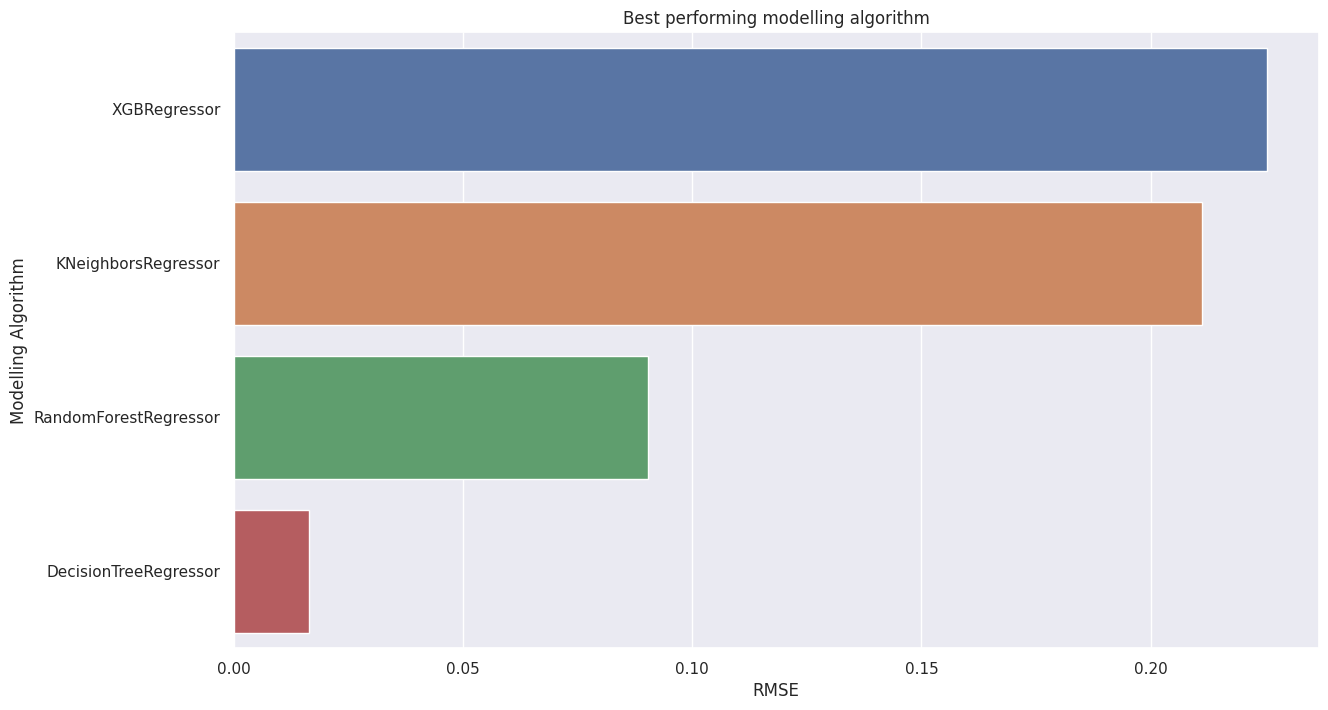

In [84]:
# Barplot to identify the best performing modelling algorithm
sns.barplot(data=rmse_table, x='RMSE', y='Modelling Algorithm').set(title='Best performing modelling algorithm');

As per the Plot Decision Regressor gives the lowest RMSE.

### Try Different Models

In [85]:
def calculate_rmse(model):
    # Fit the model
    model.fit(X_train, train_targets)

    # Generate predictions
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # Compute RMSE
    train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
    val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
    return train_rmse, val_rmse

### Linear models

When we refer to a linear model, it means that the model is constructed by combining the features in a linear manner. This involves assigning a weight to each feature, based on the training data. These weights help create a model that can make predictions or estimates of the target value.

1. Linear regression

In [86]:
train_rmse, val_rmse = calculate_rmse(LinearRegression())
print('LinearRegression: \n Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

LinearRegression: 
 Train RMSE: 0.25831567878025774, Validation RMSE: 0.2568478960810301


In [87]:
import gc
gc.collect()

3201

### Tree Based Models

Tree-based classification models are a type of machine learning algorithm that uses conditional statements to separate data into groups. The more splits it makes, the better it can predict outcomes. The final model can be seen as a set of logical tests that describe the data. Decision trees are popular for smaller data sets because they are easy to use and understand.

1. Fit & Transform the Decision Tree

In [88]:
tree = DecisionTreeRegressor(random_state=42)
calculate_rmse(tree)
print('DecisionTreeRegressor: \n Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

DecisionTreeRegressor: 
 Train RMSE: 0.25831567878025774, Validation RMSE: 0.2568478960810301


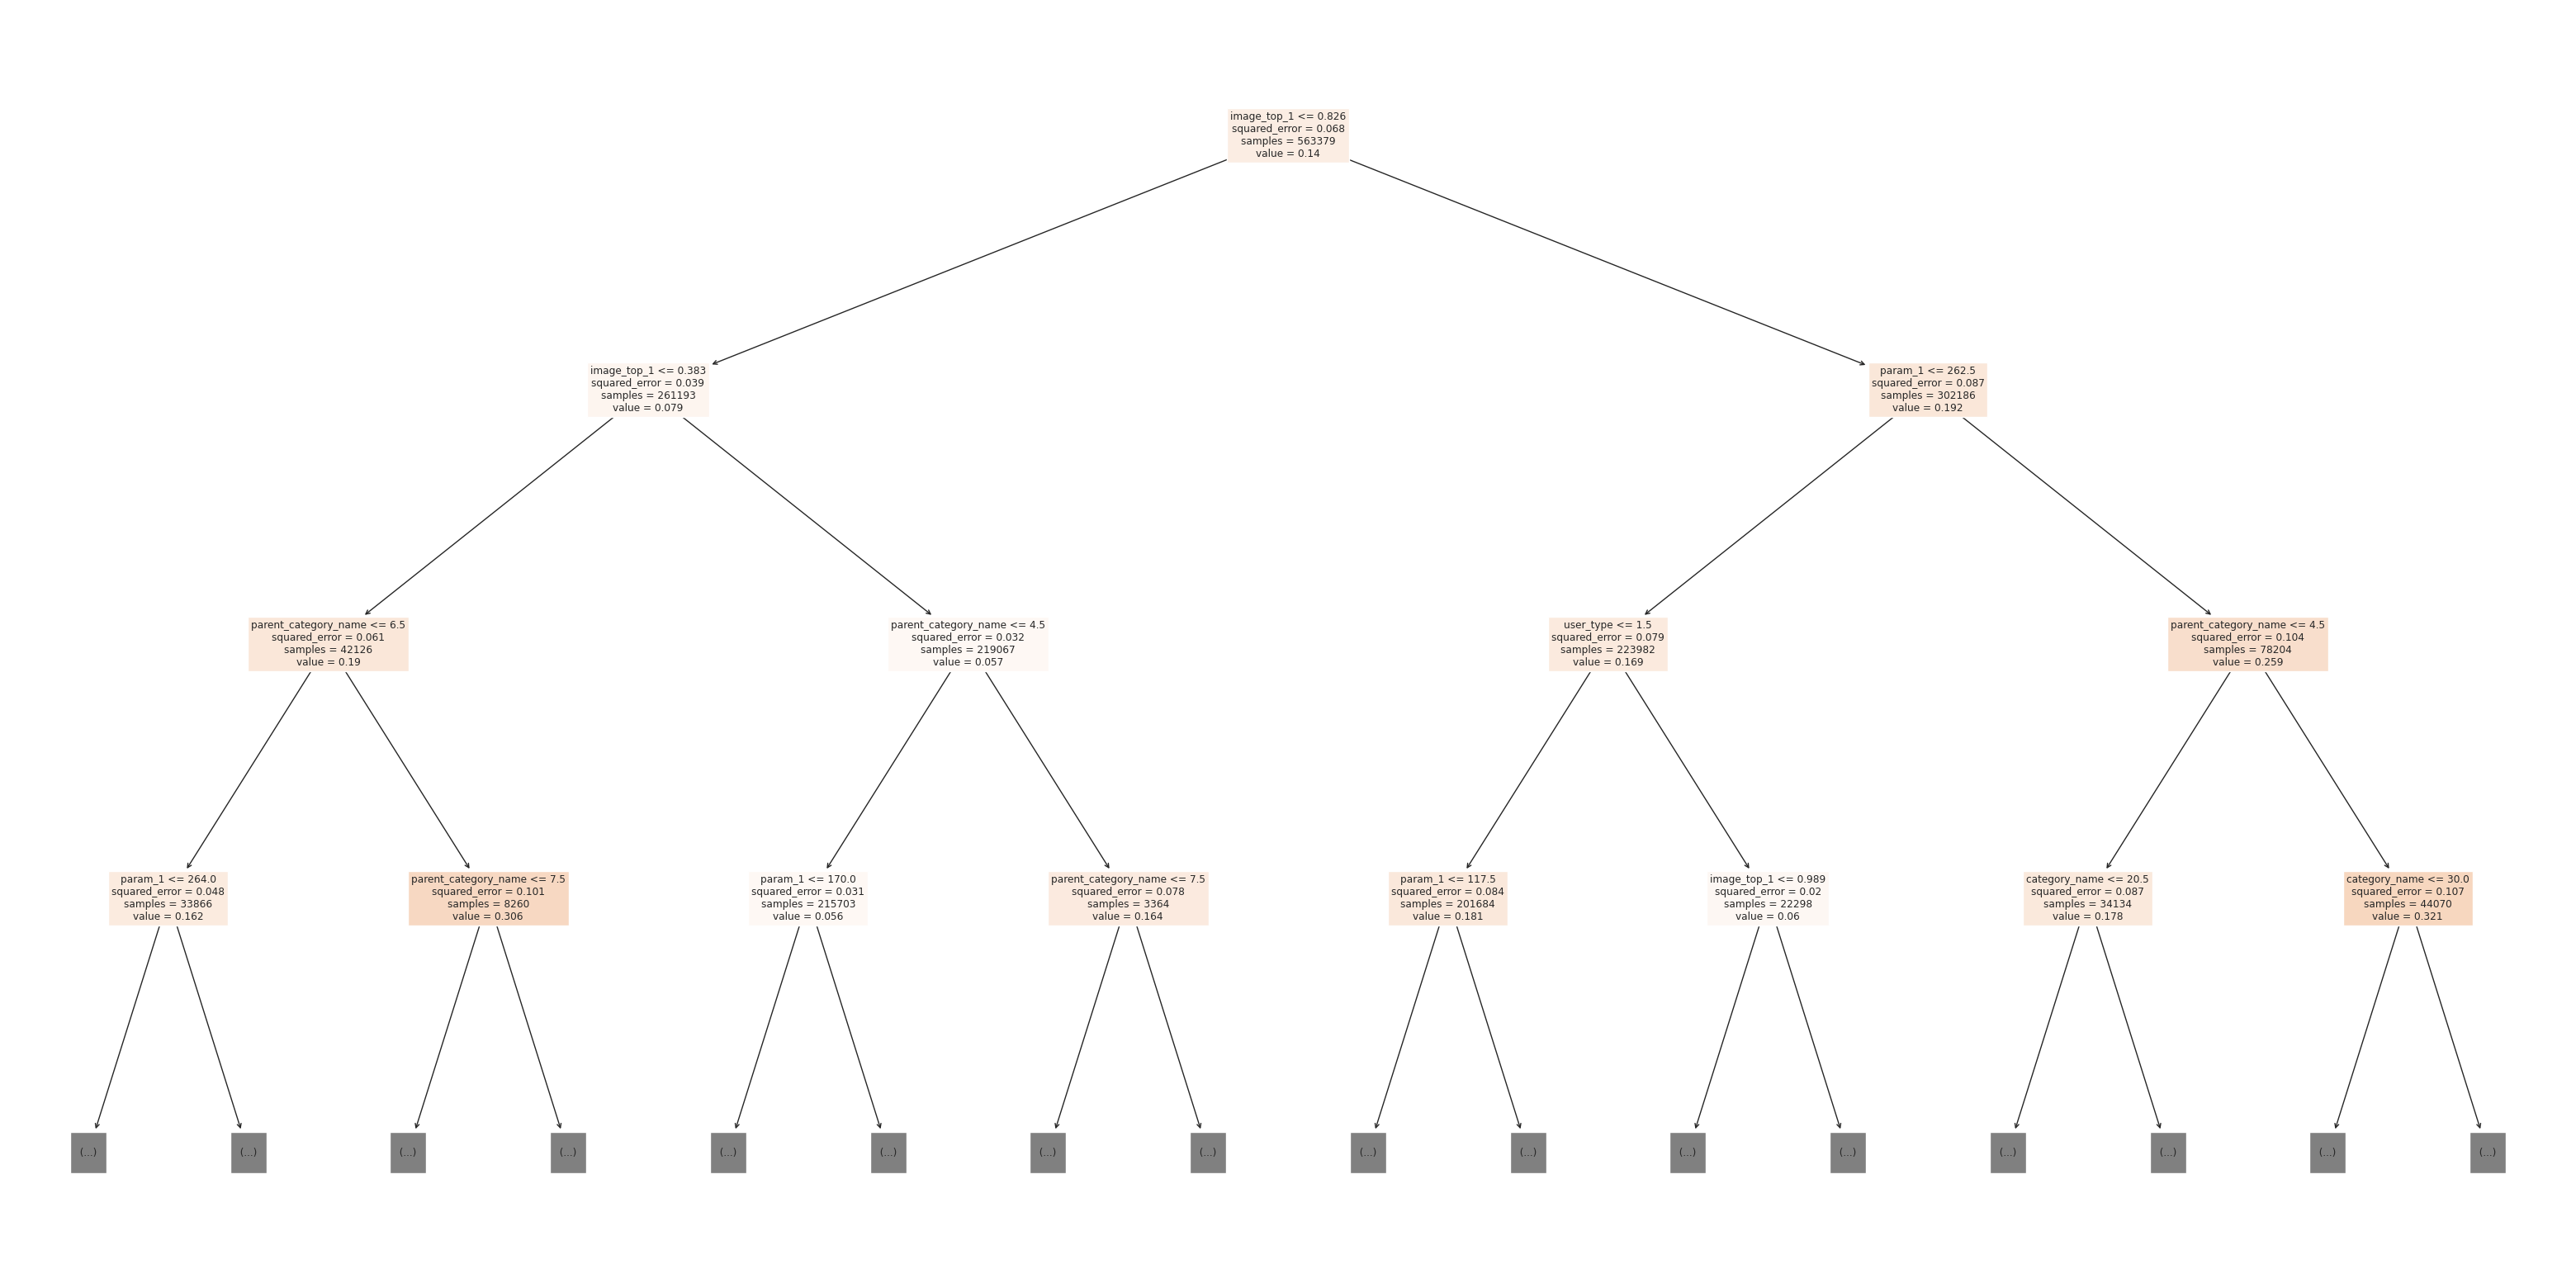

In [89]:
plt.figure(figsize=(40, 20))
plot_tree(tree, max_depth=3, filled=True, feature_names=numeric_cols + categorical_cols);

### Random forest regressor

Each decision tree on its own may have a lot of variability, but when we bring them all together in parallel, the overall variability decreases. This is because each decision tree is trained perfectly on a specific subset of data, and the final output is not dependent on just one tree, but on multiple trees. In classification problems, the final output is determined by using a majority voting system.

To put it simply, when we combine multiple decision trees, the overall variability decreases. Each tree is trained on a different subset of data, and the final output is determined by considering the majority decision from all the trees.

In [90]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
calculate_rmse(rf)
print('RandomForestRegressor: \n Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

RandomForestRegressor: 
 Train RMSE: 0.25831567878025774, Validation RMSE: 0.2568478960810301


2. Feature Importance

In [91]:
rf.feature_importances_

array([3.14843044e-02, 1.78867836e-01, 1.00638363e-01, 1.37533413e-01,
       3.11618677e-02, 2.69481391e-02, 5.78764309e-02, 2.59264144e-01,
       2.53743542e-02, 9.29934681e-06, 8.55388626e-02, 5.66888869e-02,
       8.61409950e-03])

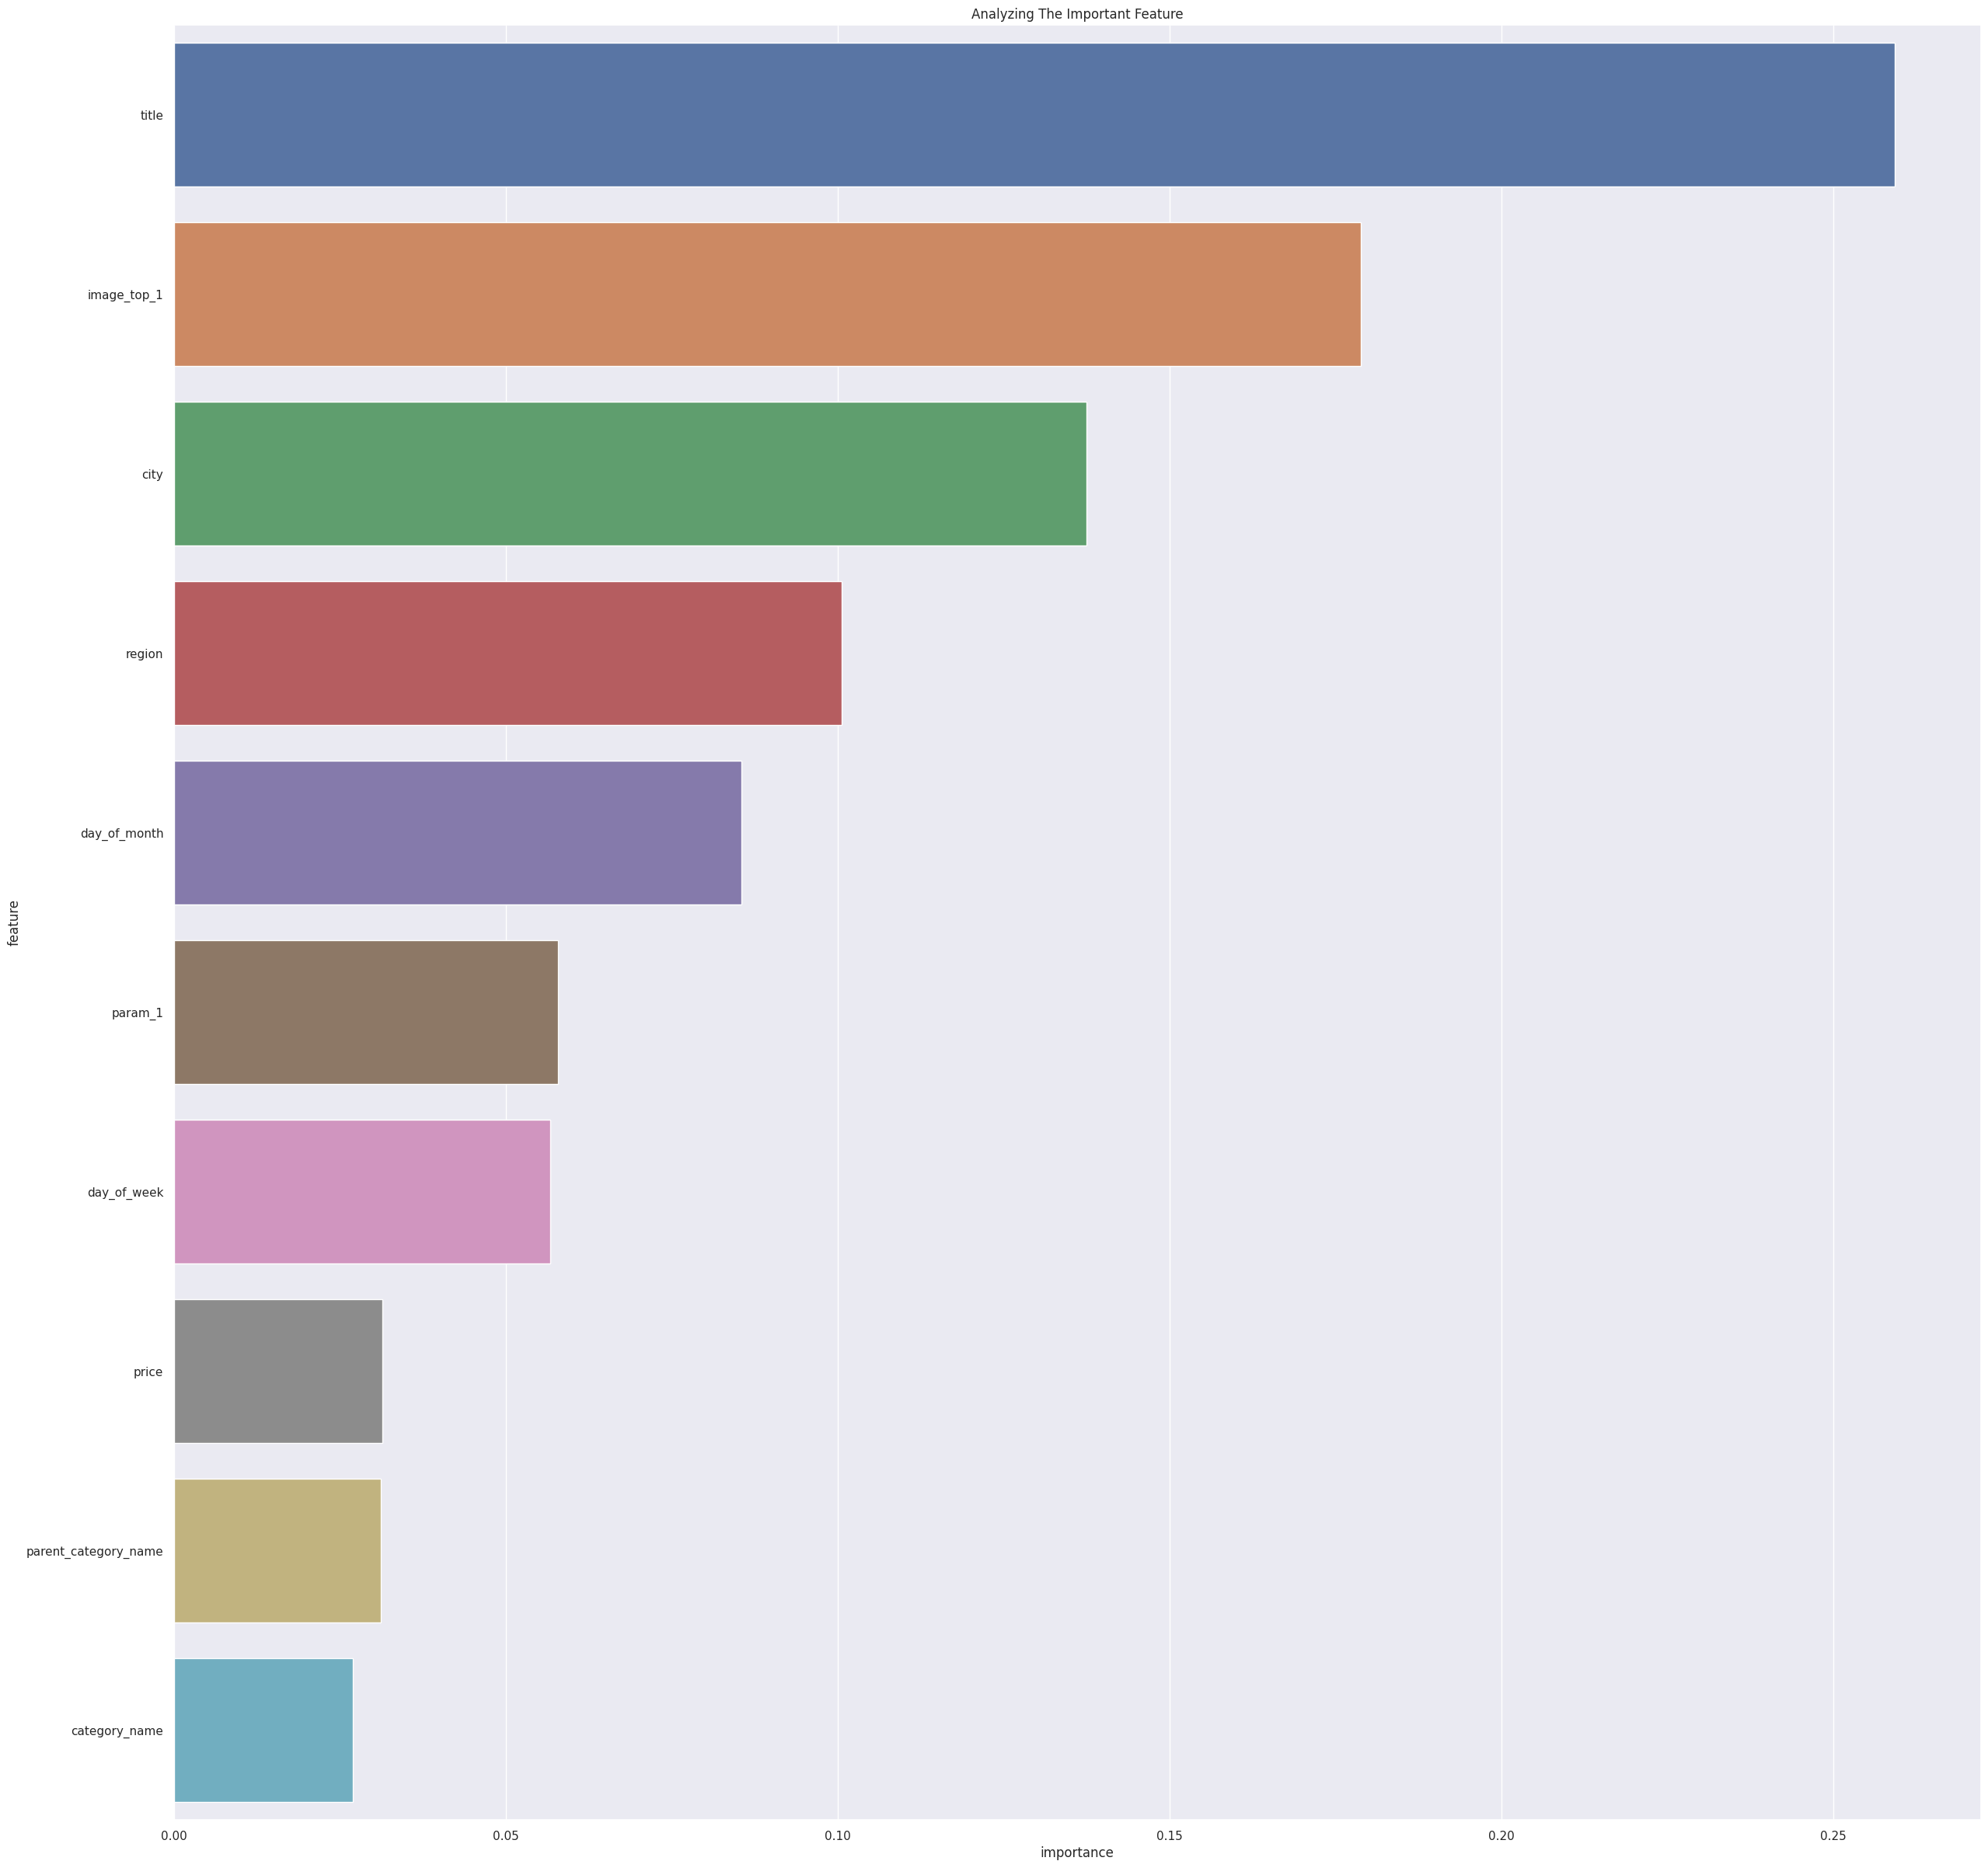

In [145]:
importance_df = pd.DataFrame({
    'feature': numeric_cols+categorical_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)
sns.barplot(data=importance_df.head(10), x='importance', y='feature').set(title='Analyzing The Important Feature');

By looking at above graph we can say that

- title is the most important feature
- image_top_1 is the second most important feature later comes
- price, city, region and so on.


__Hyperparameter Tuning and Regularization — Random Forest Regressor__

1. Helper Function to find the best hyperparameters for Random Forest Regressor

In [93]:
def test_params_rf(**params):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

2. Evaluate different hyperparameters

In [94]:
test_params_rf(n_estimators=10, max_depth=20)

(0.18324429295774888, 0.23583454705545065)

In [95]:
test_params_rf(n_estimators=20)

(0.09767487959078386, 0.24249326967968532)

In [96]:
test_params_rf(n_estimators=50)

(0.09234241542380332, 0.23910126201173948)

In [97]:
gc.collect()

3838

In [98]:
def test_param_and_plot_rf(param_name, param_values):
    train_errors, val_errors = [], []
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params_rf(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

Figuring out the best value max_depth

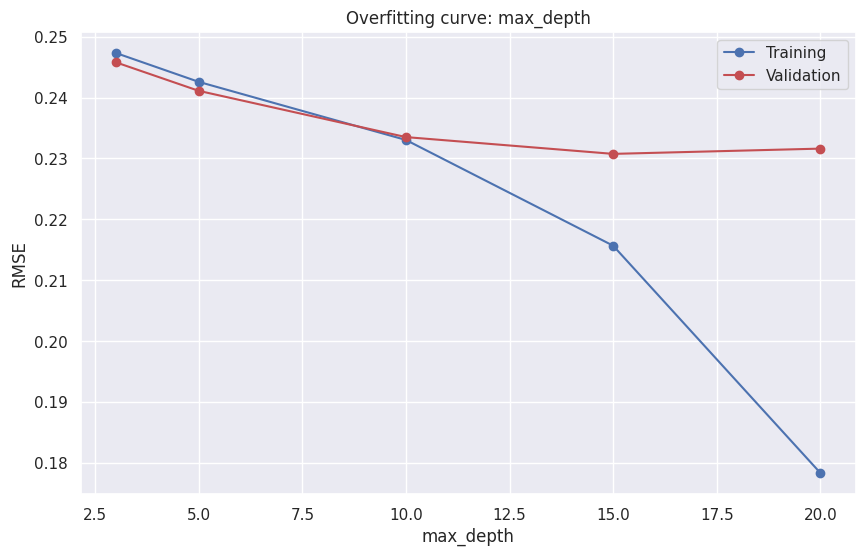

In [99]:
test_param_and_plot_rf('max_depth', [3, 5, 10, 15, 20])

From the above graph we can choose the max_depth of 9 will be good.

In [100]:
test_params_rf(n_estimators=30, max_depth=9, min_samples_leaf=4, max_features=0.4)

(0.23602146495472062, 0.23535470708532233)

In [101]:
test_params_rf(n_estimators=50,
            max_depth=9,
            min_samples_leaf=4,
            min_samples_split=3,
            max_features='log2',
            max_leaf_nodes=128,
            min_impurity_decrease=1e-6,
            max_samples=0.9
           )

(0.23801261938523777, 0.23687973014701855)

In [102]:
test_params_rf(n_estimators=50,
            max_depth=9,
            min_samples_leaf=4,
            min_samples_split=3,
            max_leaf_nodes=128,
            min_impurity_decrease=1e-6,
            max_samples=0.9
           )

(0.23638320591340972, 0.23526330030822226)

In [103]:
test_params_rf(n_estimators=50,
            max_depth=15,
            min_samples_leaf=4
           )

(0.21853353932532588, 0.23060424681754477)

In [104]:
test_params_rf(n_estimators=30,
            max_depth=15,
            min_samples_leaf=4
           )

(0.21866390057027327, 0.23074760944967168)

## Training the best Model

In [105]:
%%time

tuned_rf1 = RandomForestRegressor(n_estimators=30,
            max_depth=15)
calculate_rmse(tuned_rf1)
print('RandomFRegressor: \n Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

RandomFRegressor: 
 Train RMSE: 0.25831567878025774, Validation RMSE: 0.2568478960810301
CPU times: user 1min 47s, sys: 158 ms, total: 1min 47s
Wall time: 1min 48s


In [106]:
tuned_rf2 = RandomForestRegressor(n_estimators=50,
            max_depth=9,
            min_samples_leaf=4,
            min_samples_split=3,
            max_features='log2',
            max_leaf_nodes=128,
            min_impurity_decrease=1e-6,
            max_samples=0.9)
calculate_rmse(tuned_rf2)
print('RandomForestRegressor: \n Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

RandomForestRegressor: 
 Train RMSE: 0.25831567878025774, Validation RMSE: 0.2568478960810301


In [107]:
tuned_rf1_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': tuned_rf1.feature_importances_
}).sort_values('importance', ascending=False)
tuned_rf1_importance_df

feature  importance
1                   city  0.31223034
7              user_type  0.14561932
6                  price  0.13828837
4                param_1  0.09439443
5                  title  0.06576328
3          category_name  0.06262811
8            image_top_1  0.05597445
2   parent_category_name  0.04589444
10          day_of_month  0.03520122
11           day_of_week  0.02137108
0                 region  0.01973764
12            is_weekend  0.00289161
9                  month  0.00000573

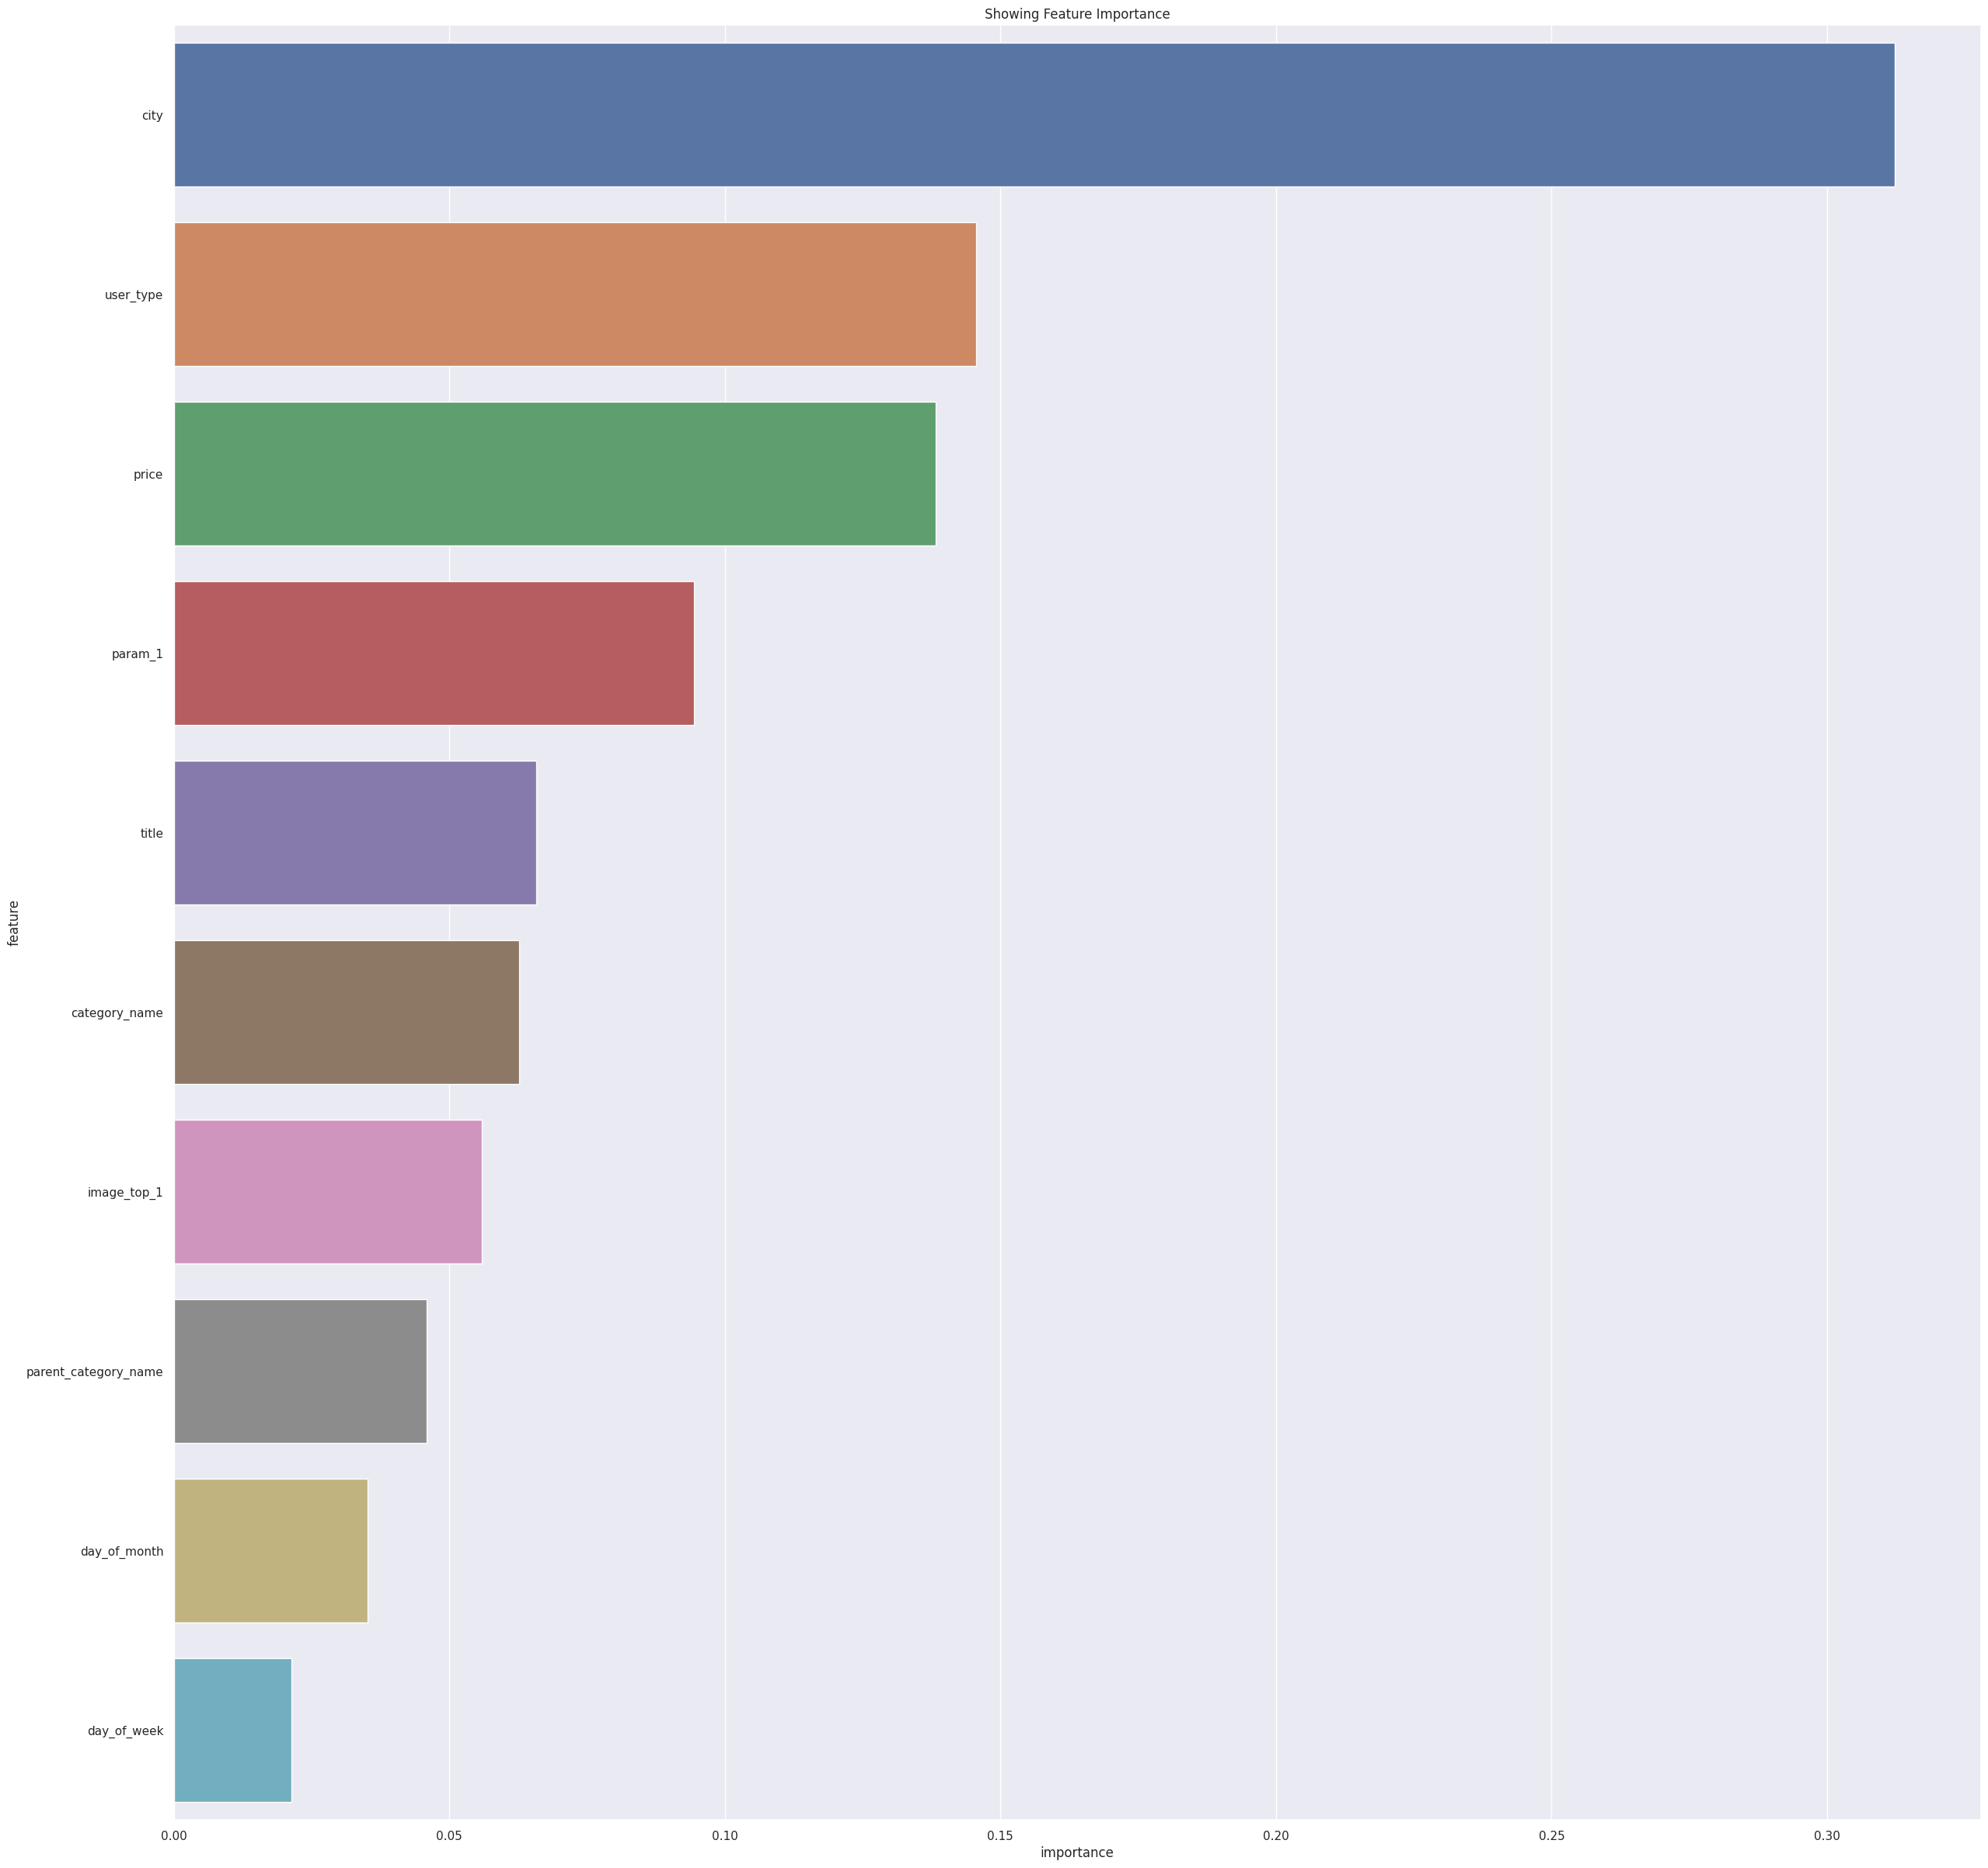

In [146]:
sns.barplot(data=tuned_rf1_importance_df.head(10), x='importance', y='feature').set(title='Showing Feature Importance');

## Gradient Boosting

Using XGBRegressor to train GBM

In [109]:
def test_params_xgb(**params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

In [110]:

from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42, n_jobs=-1)

In [111]:
test_params_xgb(n_estimators=10)

(0.2352353344787892, 0.23420915596343547)

In [112]:
test_params_xgb(n_estimators=25)

(0.23155522960787375, 0.23111516581178465)

In [113]:
test_params_xgb(n_estimators=50)

(0.22856574271228058, 0.22926179277094336)

In [114]:
test_params_xgb(n_estimators=100)

(0.22535479655667334, 0.2277950843496323)

In [115]:
def test_param_and_plot_xgb(param_name, param_values):
    train_errors, val_errors = [], []
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params_xgb(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

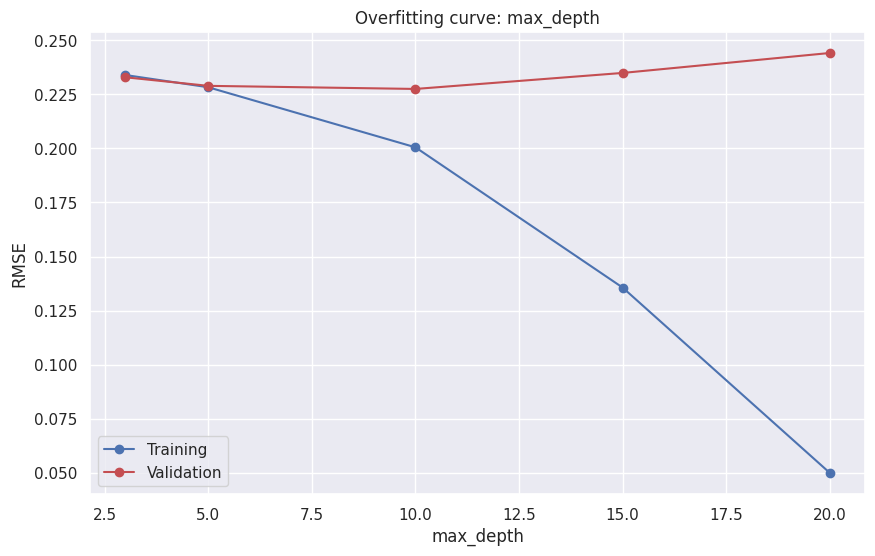

In [116]:
test_param_and_plot_xgb('max_depth', [3, 5, 10, 15, 20])

The factor learning_rate has to be applied to the prediction of each tree

In [117]:
test_params_xgb(n_estimators=5, learning_rate=0.01)

(0.42944299356798665, 0.42956478889508054)

In [118]:
test_params_xgb(n_estimators=5, learning_rate=0.3)

(0.2469488507796031, 0.24597938288060514)

In [119]:
test_params_xgb(n_estimators=5, learning_rate=0.9)

(0.23448104441693896, 0.23365943608922393)

In [120]:
test_params_xgb(booster='gbtree')

(0.22535479655667334, 0.2277950843496323)

In [121]:
xgb = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=5,
                     learning_rate=0.01, max_depth=5)
calculate_rmse(xgb)
print('XGBRegressor: \n Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

XGBRegressor: 
 Train RMSE: 0.25831567878025774, Validation RMSE: 0.2568478960810301


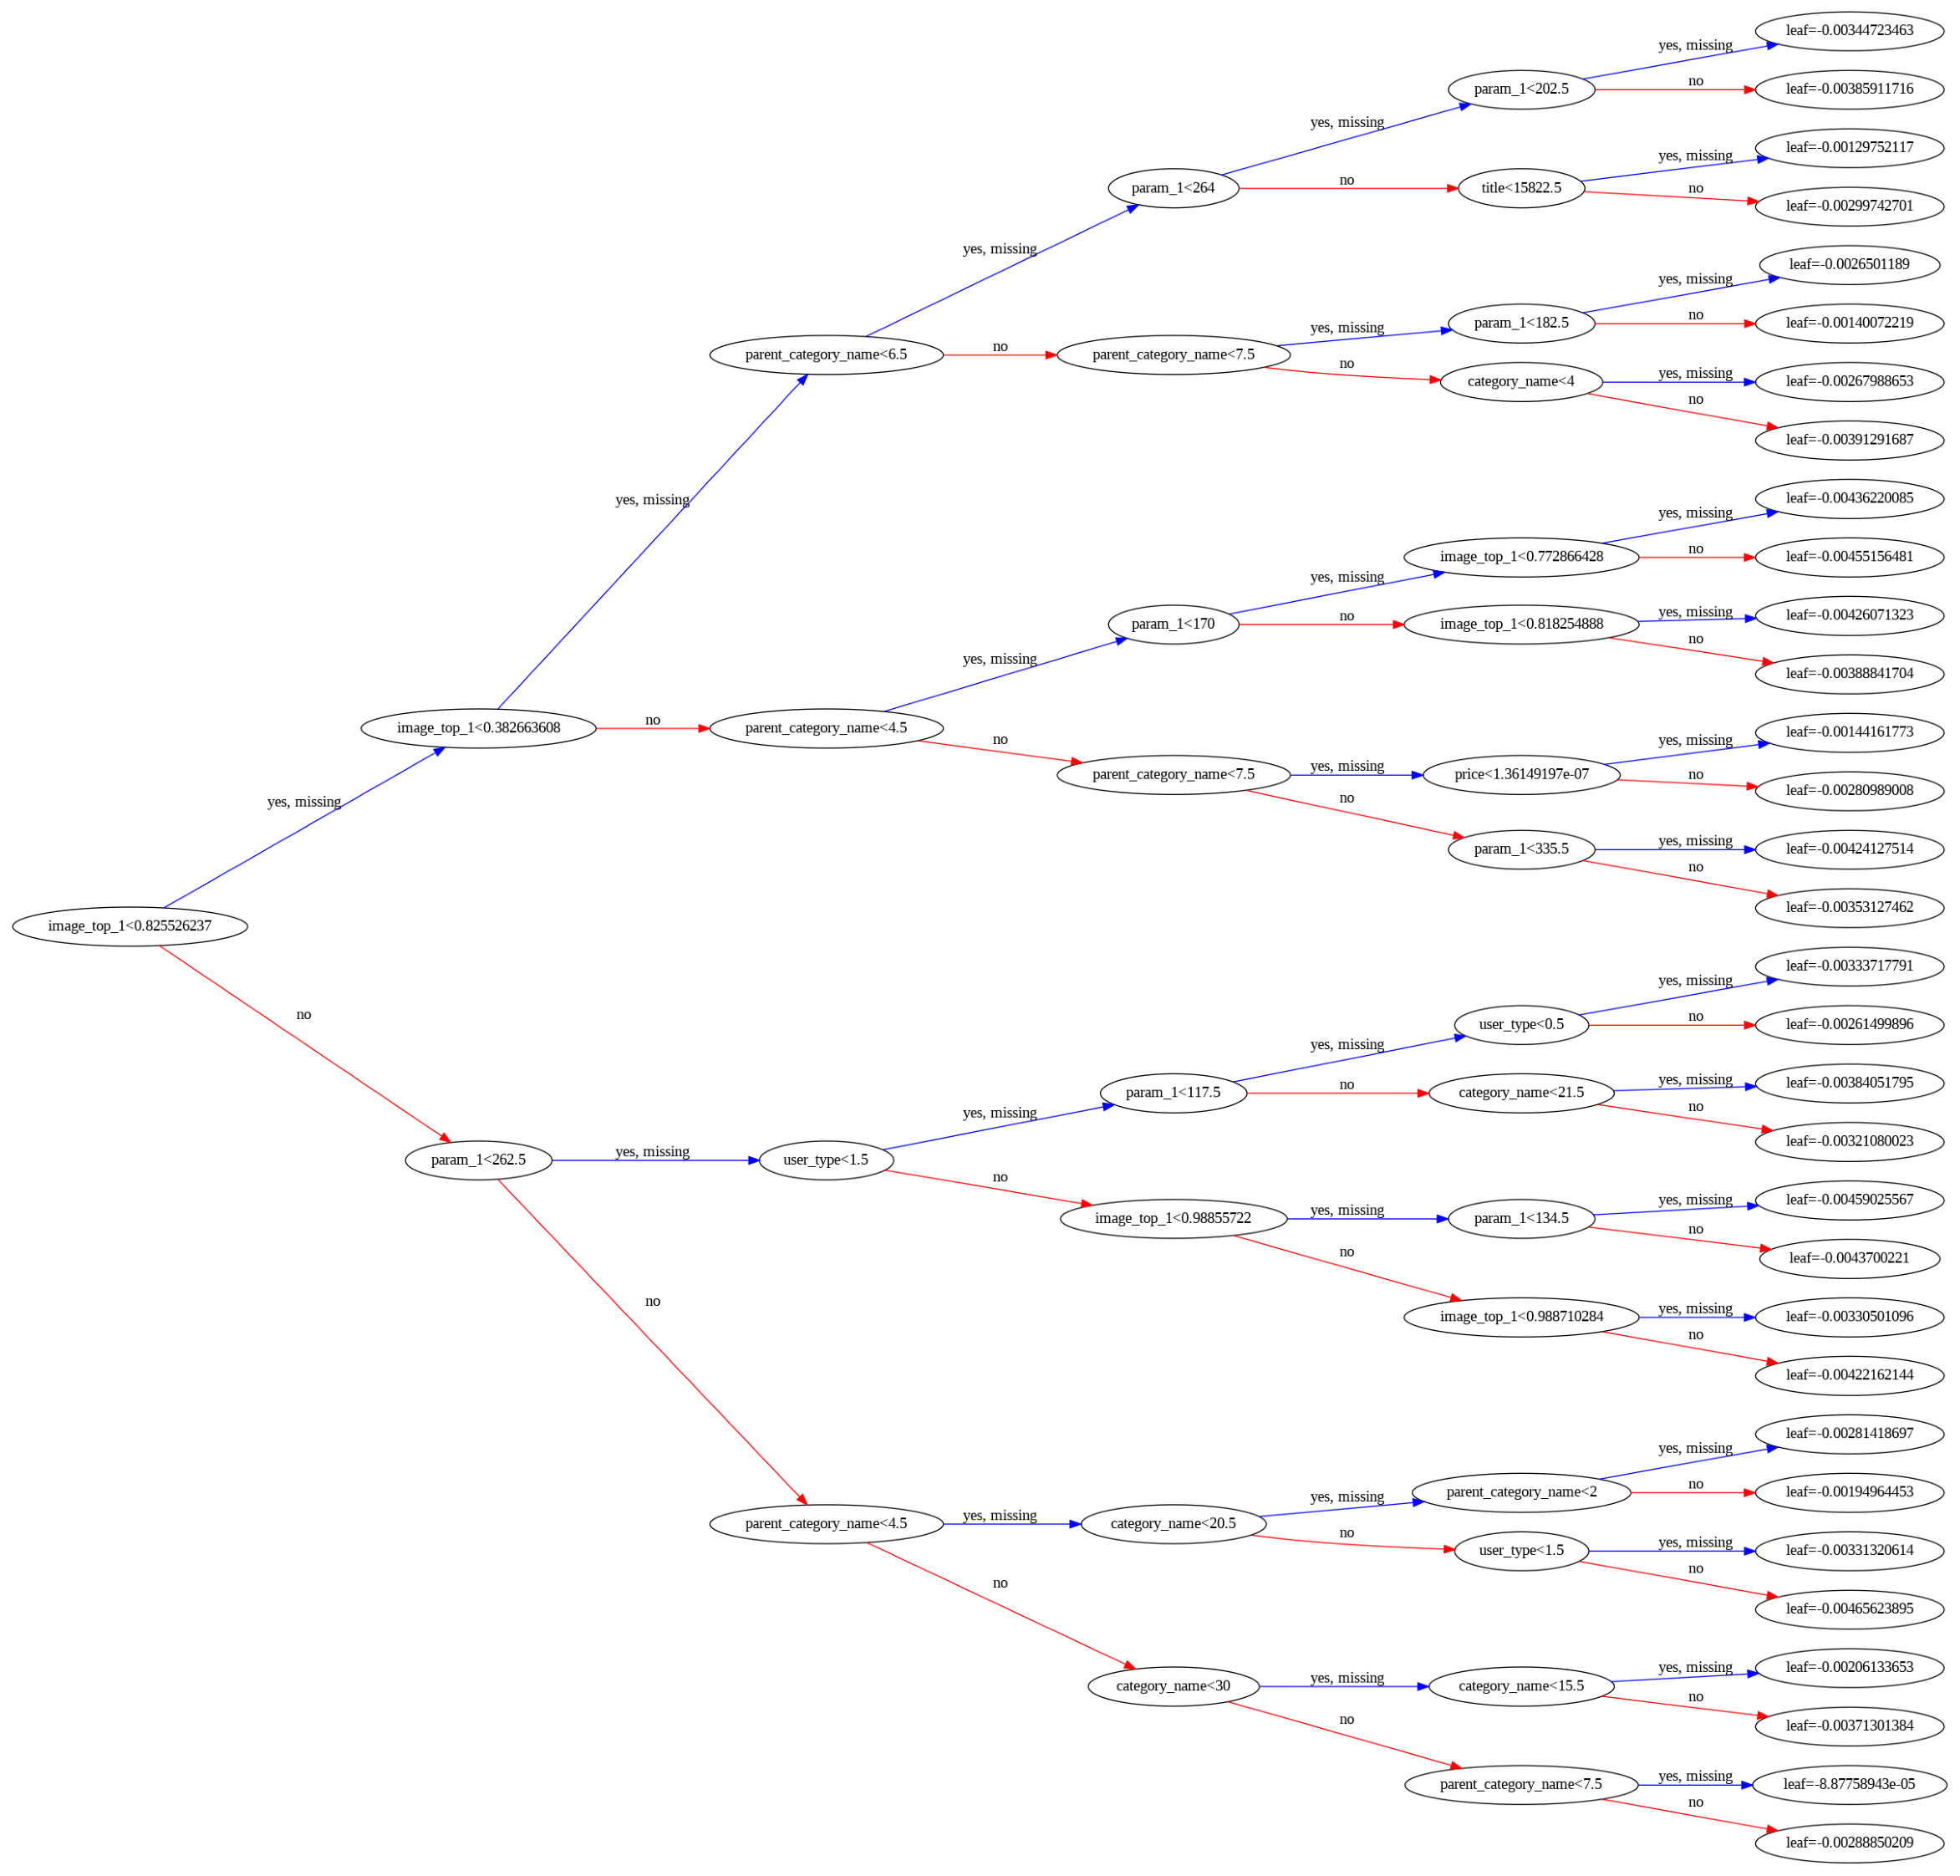

In [122]:
# Visualization

from matplotlib.pylab import rcParams
from xgboost import plot_tree

%matplotlib inline

rcParams['figure.figsize'] = 30,30
plot_tree(xgb, rankdir='LR');

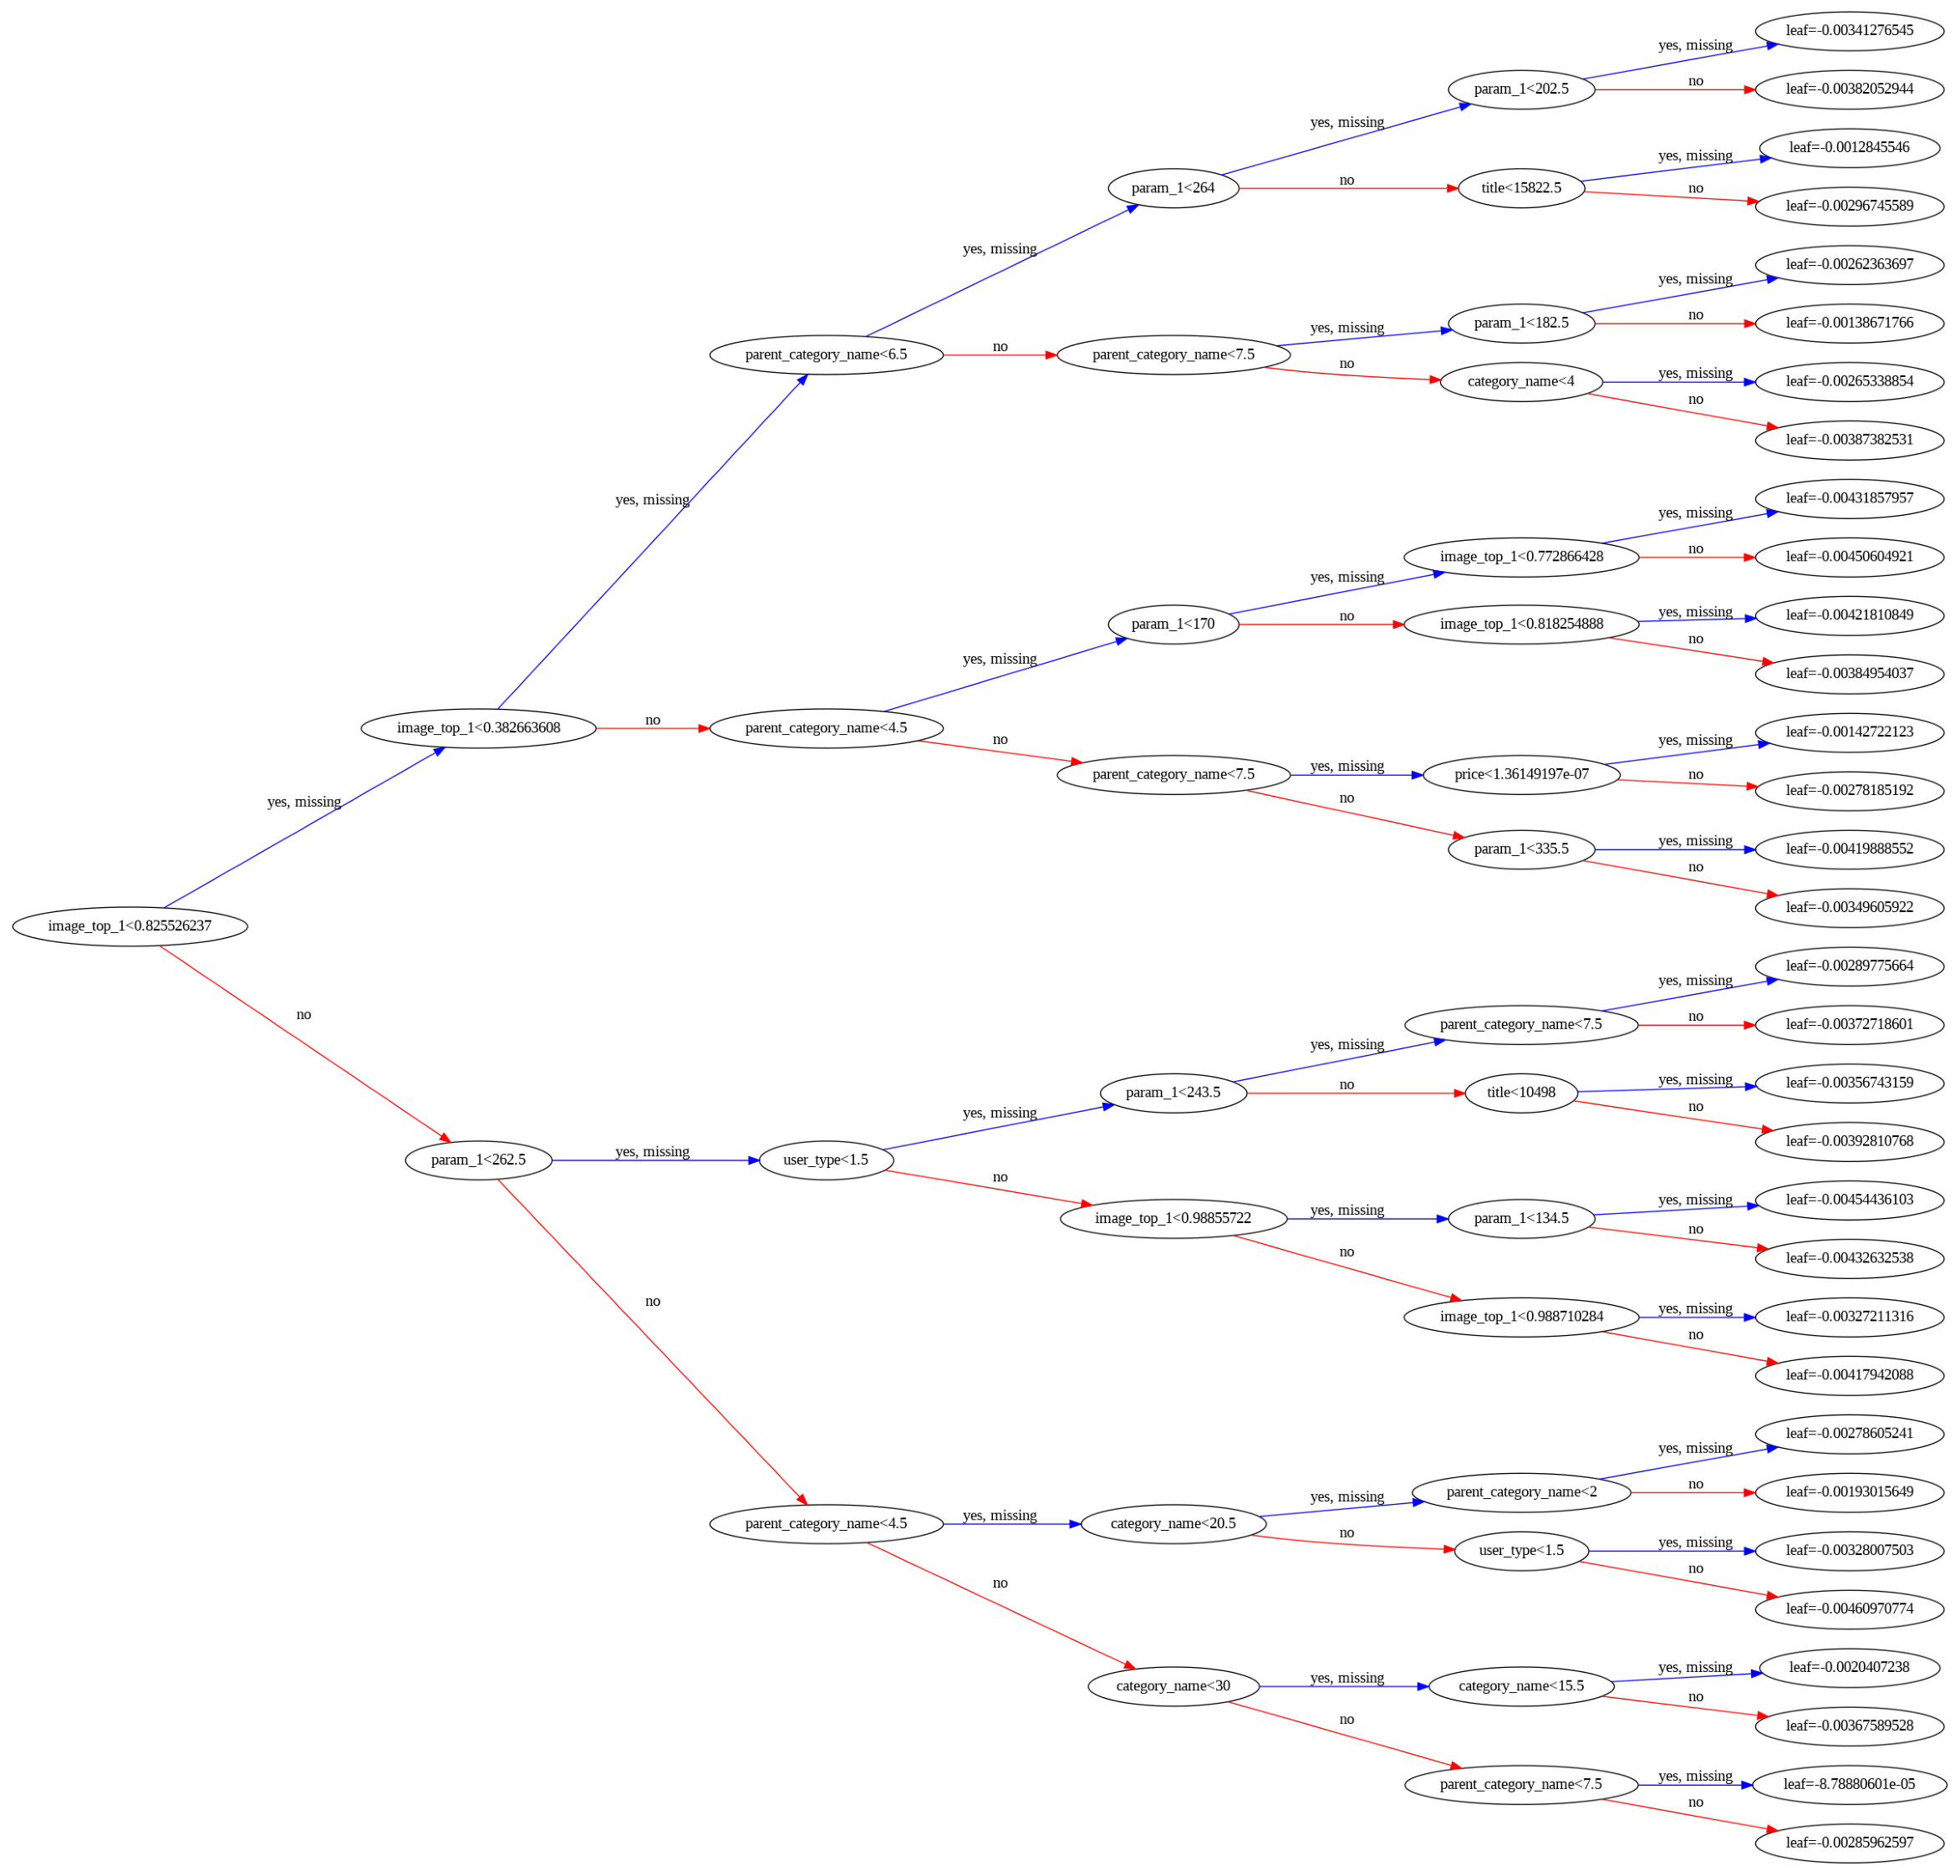

In [123]:
plot_tree(xgb, rankdir='LR', num_trees=1);

In [124]:
#feature importance score
xgb_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)
xgb_importance_df.head(10)

feature  importance
1                  city  0.45528421
8           image_top_1  0.16176178
4               param_1  0.13749534
6                 price  0.10445832
5                 title  0.10340253
7             user_type  0.03171034
0                region  0.00588746
2  parent_category_name  0.00000000
3         category_name  0.00000000
9                 month  0.00000000

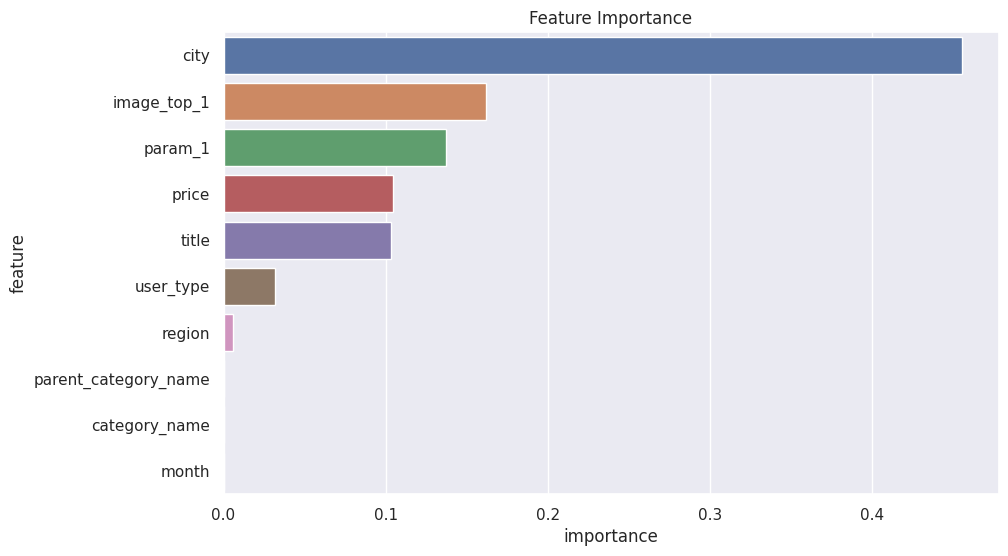

In [125]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=xgb_importance_df.head(10), x='importance', y='feature');

### Looking at individual prediction

In [126]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[categorical_cols] = input_df[categorical_cols].apply(LabelEncoder().fit_transform)
    X_input = input_df[numeric_cols + categorical_cols]
    pred = model.predict(X_input)[0]
    return pred

In [127]:
sample_input = {
    'region': 4,
    'city': 9,
    'parent_category_name': 10,
    'category_name': 22,
    'param_1': 12,
    'price': 6780.0,
    'title': 17,
    'user_type': 99,
    'image_top_1': 88,
    'month': 3,
    'day_of_month': 28,
    'day_of_week': 4,
    'is_weekend': 5}

sample_input

{'region': 4,
 'city': 9,
 'parent_category_name': 10,
 'category_name': 22,
 'param_1': 12,
 'price': 6780.0,
 'title': 17,
 'user_type': 99,
 'image_top_1': 88,
 'month': 3,
 'day_of_month': 28,
 'day_of_week': 4,
 'is_weekend': 5}

In [128]:
predicated_deal_prob = predict_input(tuned_rf1, sample_input)

In [129]:
print('The predicted probability for Online ad demand : {}'.format(predicated_deal_prob))

The predicted probability for Online ad demand : 0.27405394045054465


## Making Submission On Kaggle

In [130]:
test_preds = tuned_rf1.predict(X_test)
len(test_preds)

508438

In [131]:
print(test_preds)

[0.09055167 0.05943794 0.25852564 ... 0.03523307 0.35751341 0.0820398 ]


In [132]:
submission_df = pd.read_csv('/content/avito-demand-prediction/sample_submission.csv')

In [133]:
submission_df

item_id  deal_probability
0       6544e41a8817               0.5
1       65b9484d670f               0.5
2       8bab230b2ecd               0.5
3       8e348601fefc               0.5
4       8bd2fe400b89               0.5
...              ...               ...
508433  9f2200aed300               0.5
508434  70813f518de4               0.5
508435  a22a2eeb5dd2               0.5
508436  ed7fbb0733c1               0.5
508437  d374d332992f               0.5

[508438 rows x 2 columns]

In [134]:
submission_df.item_id.duplicated().any()

False

In [135]:
submission_df['deal_probability'] = test_preds.astype('float')

In [136]:
submission_df.fillna(0, inplace=True)
submission_df.isna().sum()

item_id             0
deal_probability    0
dtype: int64

In [137]:
submission_df.to_csv('sample_submission.csv', index=False, header=1)

In [138]:
!head submission.csv

head: cannot open 'submission.csv' for reading: No such file or directory


In [139]:
#Downloading csv
from google.colab import files
submission_df.to_csv('sample_submission', index=False)
files.download('sample_submission')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Below is the screenshot of Kaggle Score:

![sample_submission_screenshot](https://i.imgur.com/tKDyCBN.png)

Saving model

In [140]:
import joblib

In [141]:
online_ad_demand_rf = {
    'model': tuned_rf1,
    'imputer': imputer,
    'scaler': scaler,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols
    }

In [142]:
joblib.dump(online_ad_demand_rf, 'online_ad_demand_tuned_rf1.joblib')

['online_ad_demand_tuned_rf1.joblib']

In [143]:
jovian.commit(outputs=['online_ad_demand_tuned_rf1.joblib'])

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


## Conclusion



- Examined and investigated the dataset thoroughly.
- Developed a basic model with fixed parameters to serve as a reference.
- Preprocessed the data to make it suitable for machine learning models.
- Created new features that were relevant and beneficial for the models.
- Trained multiple models and optimized their hyperparameters.
- The model I finalized achieved a Kaggle score of 0.24257.



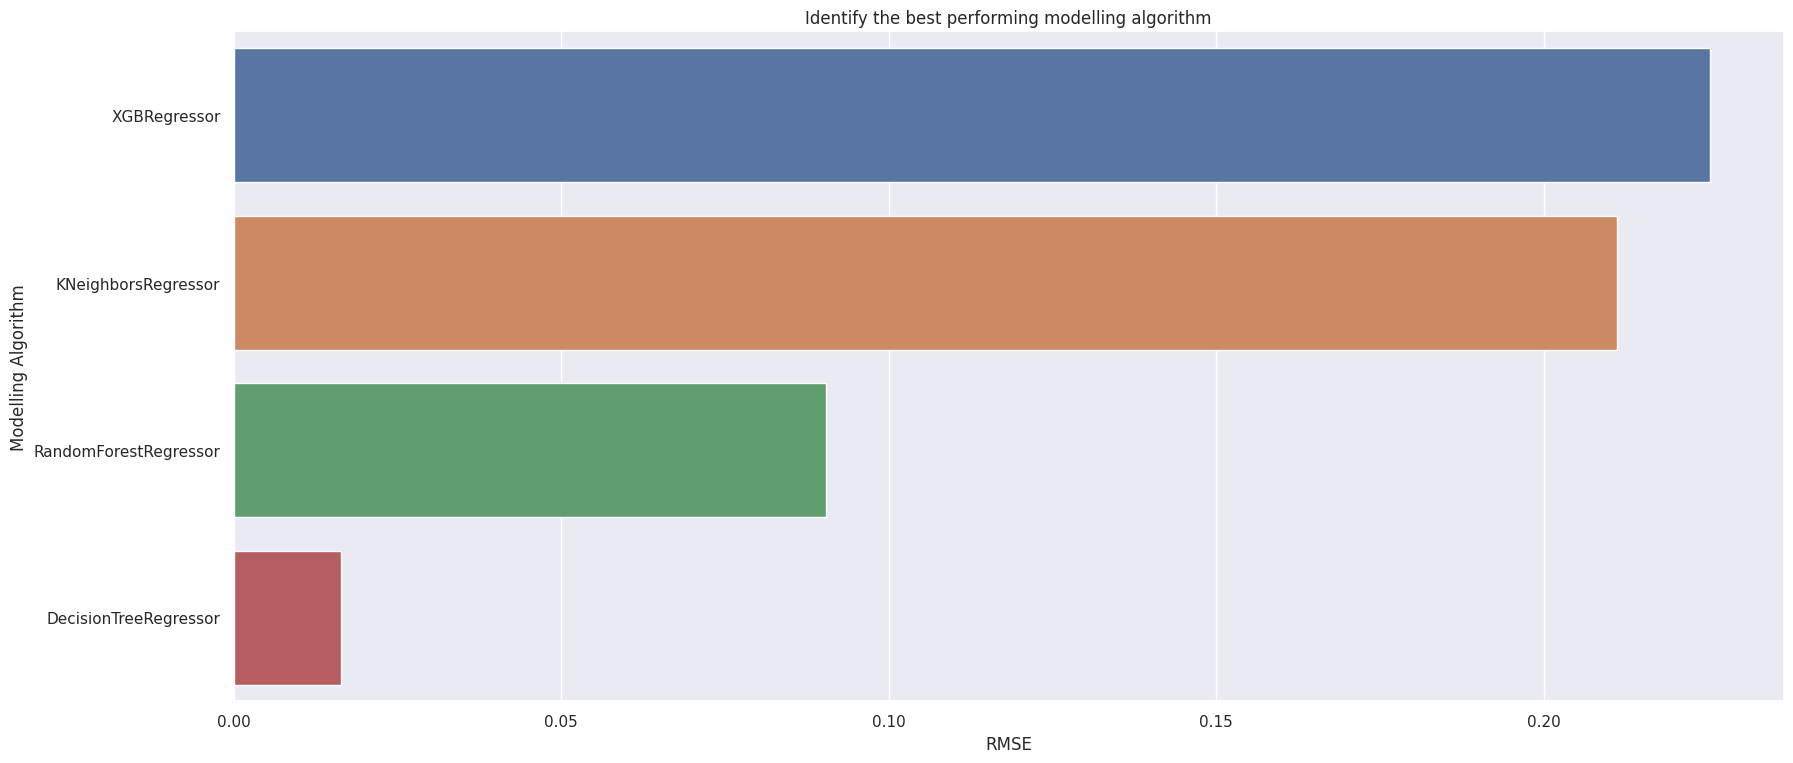

In [147]:
# Barplot to identify the best performing modelling algorithm
dimensions = (20, 8.7)
fig, ax = pyplot.subplots(figsize=dimensions)
sns.barplot(data=rmse_table, x='RMSE', y='Modelling Algorithm').set(title='Identify the best performing modelling algorithm');

## Reference


- https://www.kaggle.com/
- Linear Regression with Scikit-Learn Jovian Aakash N S
- How to approach Machine Learning Problems Jovian Aakash N S
- Gradient Boosting Machines with XGBoost Jovian Aakash N S
- kaggle notebooks
- Various Featured notebooks


# Future Work


- Attempted to enhance the prediction results by utilizing different feature selection techniques.
- Included additional cells or sections in the analysis to provide a better explanation of the findings.
- To improve the score further, I experimented with various models and evaluated their performance.
